<a href="https://colab.research.google.com/github/TMhdSofyan/Prediction-Flow-Zone-Indicator-/blob/main/%5BFINAL_MODEL%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install jcopml

In [2]:
pip install xgboost

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [104]:
df = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/gamma_interp.csv')
df.head()

,LOGFZI,FZI,CGR,DRHO,DT5,GR,HNPO,LLD,LLHR,LLS,MRES,MSFC,NPHI,NPOR,POTA,RHOB,SP,THOR,URAN
0,2.324533,211.121914,31.992576,0.034071,86.073454,47.128474,0.184824,1.484896,1.989065,1.370871,0.067983,1.299775,0.179966,0.179166,1.292815,2.376139,4.092643,2.646898,2.012321
1,2.460043,288.431455,31.976041,0.025724,86.340619,48.285009,0.183564,1.479856,1.984340,1.344729,0.067904,1.278673,0.184376,0.181292,1.281476,2.365824,3.945005,2.688867,1.995077
2,2.438689,274.592462,36.236242,0.009850,87.020905,50.670716,0.181900,1.491390,1.827785,1.336755,0.067821,1.246173,0.187421,0.179666,1.476265,2.335299,4.080146,2.949177,1.992421
3,2.697101,497.852972,42.122592,0.003631,87.951610,53.894521,0.173462,1.559632,1.893686,1.371531,0.067900,1.095846,0.185625,0.182018,1.743465,2.322451,4.771490,3.316663,1.904021
4,2.265888,184.453837,42.361279,0.014313,88.442537,54.477657,0.188333,1.590263,2.136641,1.372559,0.067900,1.328147,0.184468,0.185889,1.781504,2.329119,4.248235,3.220796,1.711496


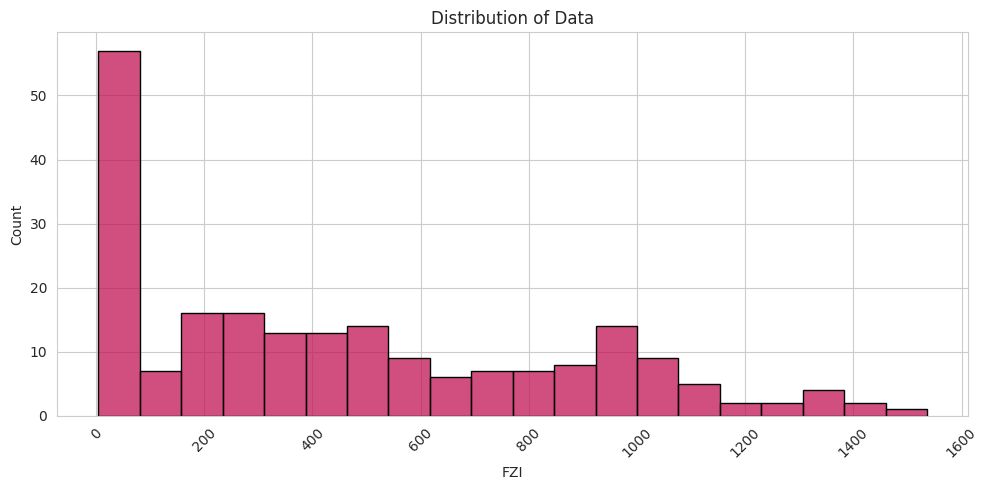

In [112]:
# Read data from CSV file
data = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/gamma_interp.csv')['FZI']

# Plot histogram using seaborn
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data, color='#c21454', edgecolor='black', bins=20)

# Customize plot
plt.title('Distribution of Data')
plt.xlabel('FZI')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Adjust color palette
sns.set_palette('Set2')

# Adjust the layout
plt.tight_layout()

# Show plot
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Distribution of data_FZI.png', dpi=600)
plt.show()

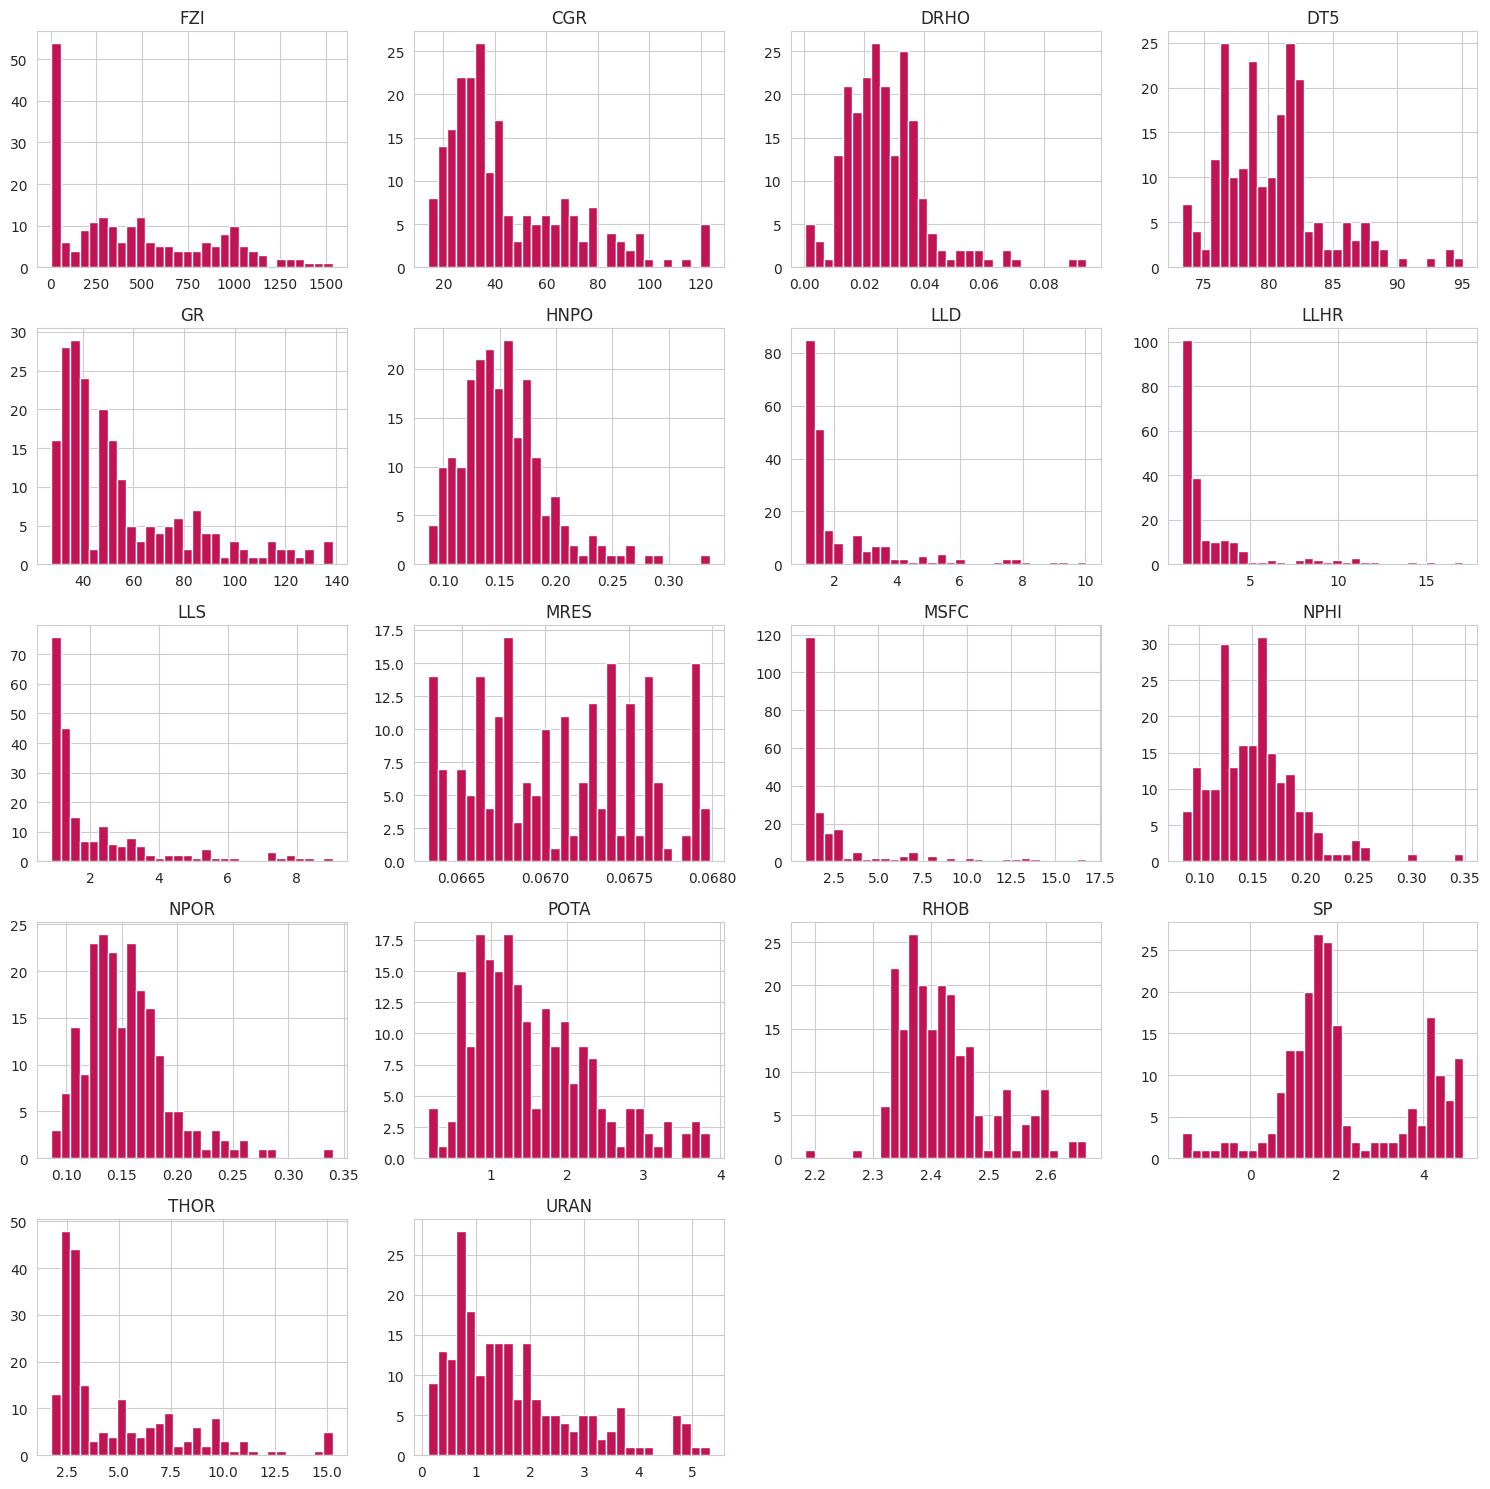

In [111]:
import matplotlib.pyplot as plt

# Assuming df is your pandas DataFrame
axes = df.hist(bins=30, figsize=(15, 15), color='#c21454')

# Adjust the layout
plt.tight_layout()

# Get the figure object from one of the axes
fig = axes[0][0].get_figure()


# Save the figure
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Histogram_.png', dpi=600)

# Show the plot
plt.show()

KeyboardInterrupt: ignored

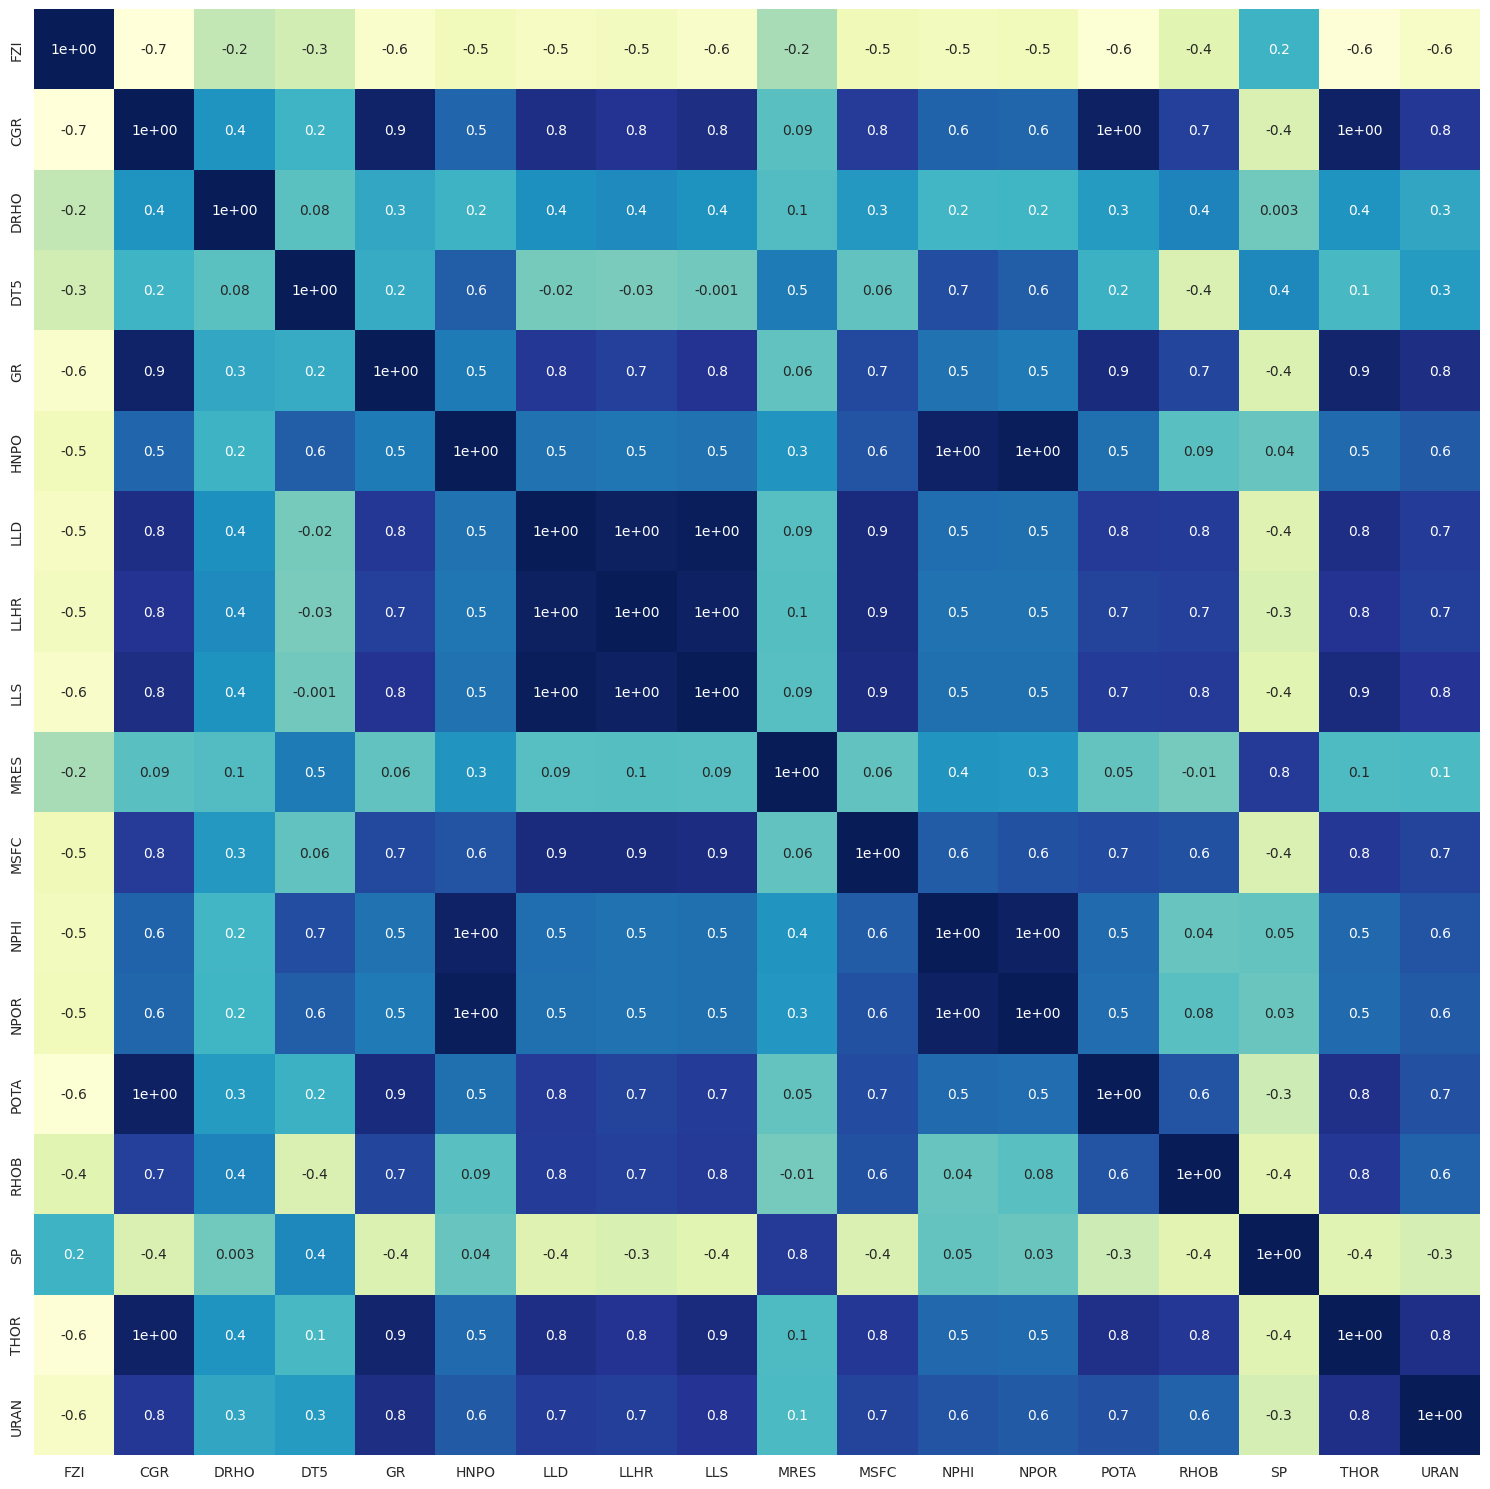

In [105]:
df = df.drop(columns = ['LOGFZI'])
#X = data[['CGR', 'DRHO', 'DT5', 'GR', 'HNPO', 'LLD', 'LLHR', 'LLS', 'MRES', 'MSFC', 'NPHI', 'NPOR', 'RHOB', 'SP', 'THOR', 'URAN', 'POTA']]
#df = df[['LOGFZI', 'CGR', 'GR','LLD', 'LLS','LLHR', 'MRES', 'MSFC', 'NPOR']]

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), cmap= "YlGnBu", cbar= False, annot= True, square= True, fmt= '.1')

# Adjust the layout
plt.tight_layout()

#fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Corr Plot.png', dpi=600)
plt.show()

In [106]:
X = df.drop(columns="FZI")
y = df.FZI

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((159, 17), (53, 17), (159,), (53,))

In [107]:
X_train.columns

Index(['CGR', 'DRHO', 'DT5', 'GR', 'HNPO', 'LLD', 'LLHR', 'LLS', 'MRES',
       'MSFC', 'NPHI', 'NPOR', 'POTA', 'RHOB', 'SP', 'THOR', 'URAN'],
      dtype='object')

In [108]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [109]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 63, 'algo__max_features': 0.9455490474077703, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 113}
0.9141147315883414 0.6938660144092824 0.6965649788171682


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)


Training Metrics:
MSE: 0.044312468631854125
MAE: 0.14663874198700869
RMSE: 0.21050526984342727

Testing Metrics:
MSE: 0.06052449989302453
MAE: 0.1906659504927358
RMSE: 0.2460172755987362


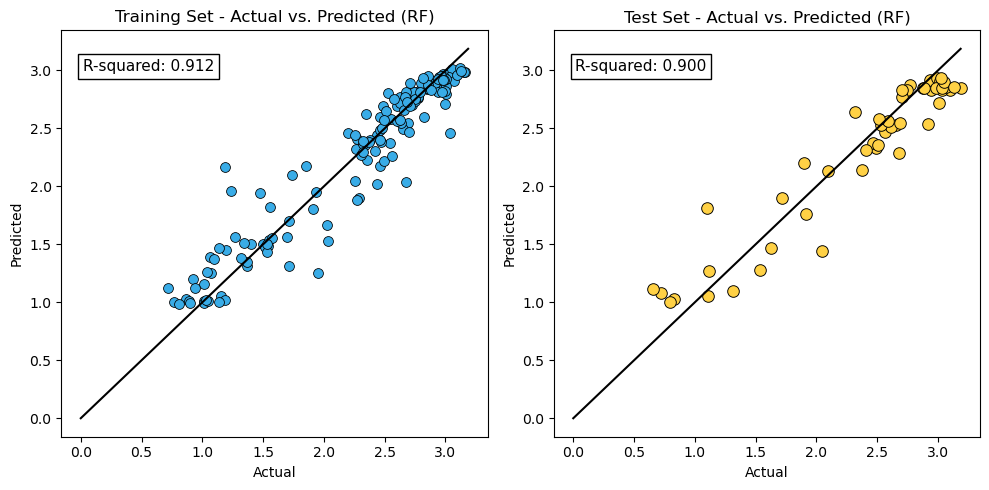

In [ ]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'minmax'), X.columns )])


from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model_XGB = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGB.fit(X_train, y_train)

print(model_XGB.best_params_)
print(model_XGB.score(X_train, y_train), model_XGB.best_score_, model_XGB.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6918516030703091, 'algo__gamma': 1, 'algo__learning_rate': 0.1216411342539395, 'algo__max_depth': 3, 'algo__n_estimators': 185, 'algo__reg_alpha': 0.011502956321912733, 'algo__reg_lambda': 0.009461469059966103, 'algo__subsample': 0.7865052773762229}
0.8865354151205828 0.7963521977048922 0.8789860953347982


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

Training Metrics:
MSE: 0.056254988612137166
MAE: 0.18346816220399792
RMSE: 0.23718134119727285

Testing Metrics:
MSE: 0.06386166210936026
MAE: 0.20760026649944488
RMSE: 0.2527086506421184


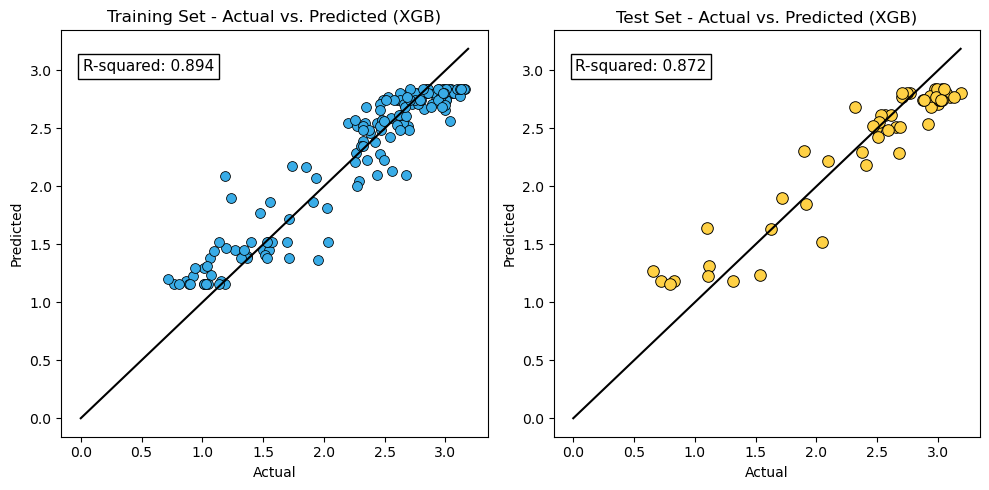

In [ ]:
# Predict on training and test sets
y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (XGB)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (XGB)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'algo__C': 12.746711578215054, 'algo__gamma': 0.4374364439939081}
0.9239807233793689 0.8441520720665184 0.8824080735157898


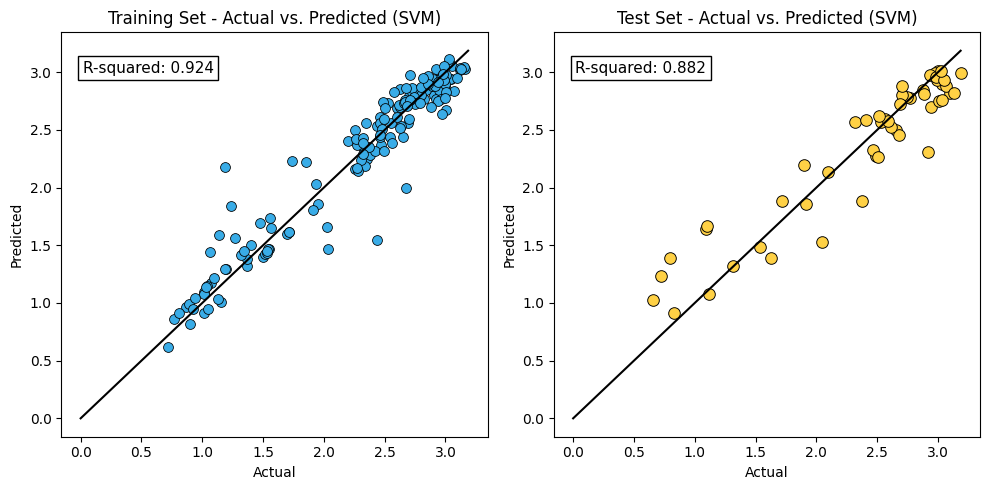

In [41]:
from sklearn.svm import SVR
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'minmax'), X.columns )])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model_SVM = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_SVM.fit(X_train, y_train)

print(model_SVM.best_params_)
print(model_SVM.score(X_train, y_train), model_SVM.best_score_, model_SVM.score(X_test, y_test))

# Predict on training and test sets
y_train_pred = model_SVM.predict(X_train)
y_test_pred = model_SVM.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (SVM)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (SVM)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_SVM.predict(X_train)
y_test_pred = model_SVM.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

Training Metrics:
MSE: 0.037689853139120474
MAE: 0.131874118413839
RMSE: 0.19413874713493048

Testing Metrics:
MSE: 0.06205581000546622
MAE: 0.1807086243590565
RMSE: 0.24911003593887224


/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (16, 8, 4), 'mlp__alpha': 0.001, 'mlp__activation': 'identity'}
0.8128973231897826 0.7805519438490433 0.823576626092723


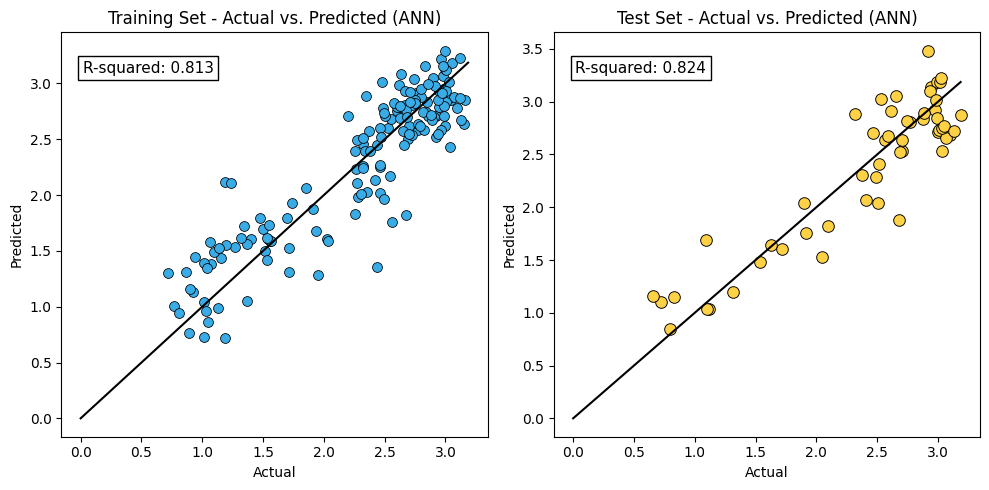

In [44]:
from sklearn.neural_network import MLPRegressor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform= 'yeo-johnson'), X.columns )])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(random_state=42))
])

parameter = {
    "mlp__alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    "mlp__hidden_layer_sizes": [(16, 8, 4), (16, 4), (8, 4), (13, 8, 2), (32, 16, 2), (64, 32, 16, 8, 4, 2)],
    "mlp__learning_rate_init": [0.001, 0.005, 0.01],
    "mlp__activation": ["identity"]
}

model_ANN = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_ANN.fit(X_train, y_train)

print(model_ANN.best_params_)
print(model_ANN.score(X_train, y_train), model_ANN.best_score_, model_ANN.score(X_test, y_test))

# Predict on training and test sets
y_train_pred = model_ANN.predict(X_train)
y_test_pred = model_ANN.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (ANN)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (ANN)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_ANN.predict(X_train)
y_test_pred = model_ANN.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

Training Metrics:
MSE: 0.0927642661756083
MAE: 0.24061576964589787
RMSE: 0.3045722675747224

Testing Metrics:
MSE: 0.09310244078009366
MAE: 0.24437472962938436
RMSE: 0.3051269256884644


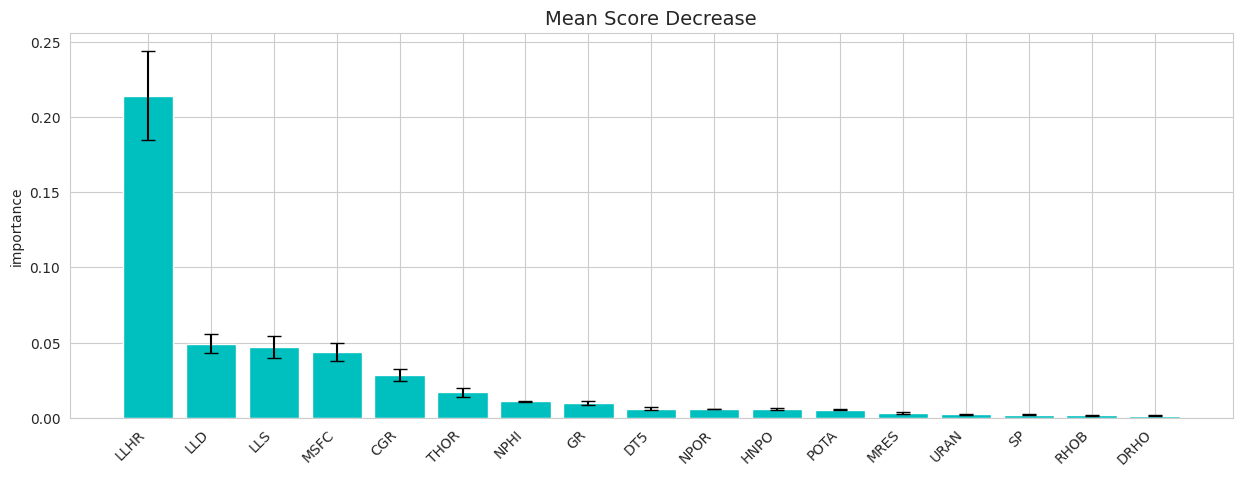

In [45]:
from jcopml.plot import plot_residual

df_imp = mean_score_decrease(X_train, y_train, model_RF, plot=True, topk = 18)
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Features importance.png', dpi=600)

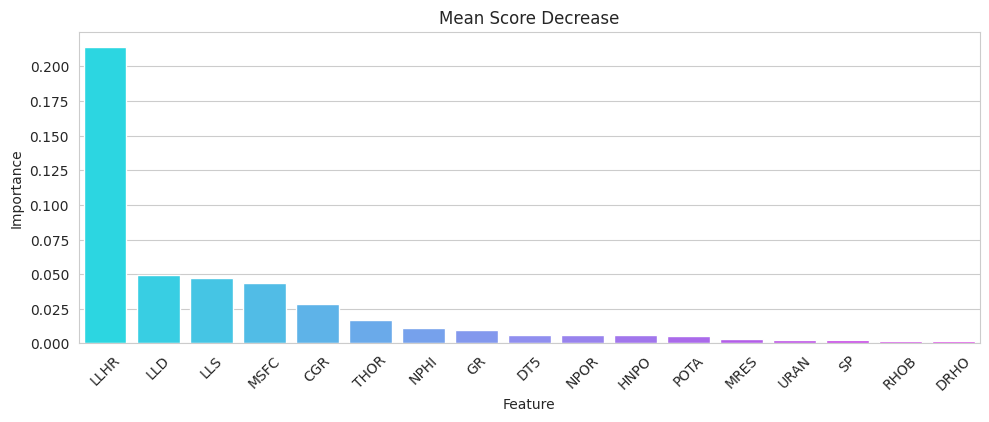

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_residual(df_imp):
    fig, ax = plt.subplots(figsize=(10, 4.325))  # Create a figure and axis object
    sns.barplot(x='feature', y='importance', data=df_imp, palette='cool', ax=ax)
    plt.xticks(rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Mean Score Decrease')
    plt.tight_layout()
    return fig  # Return the figure object

df_imp = mean_score_decrease(X_train, y_train, model_RF, plot=False, topk=18)
fig = plot_residual(df_imp.head(18))  # Receive the figure object
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Features_importance.png', dpi=600)
plt.show()

<Axes: >

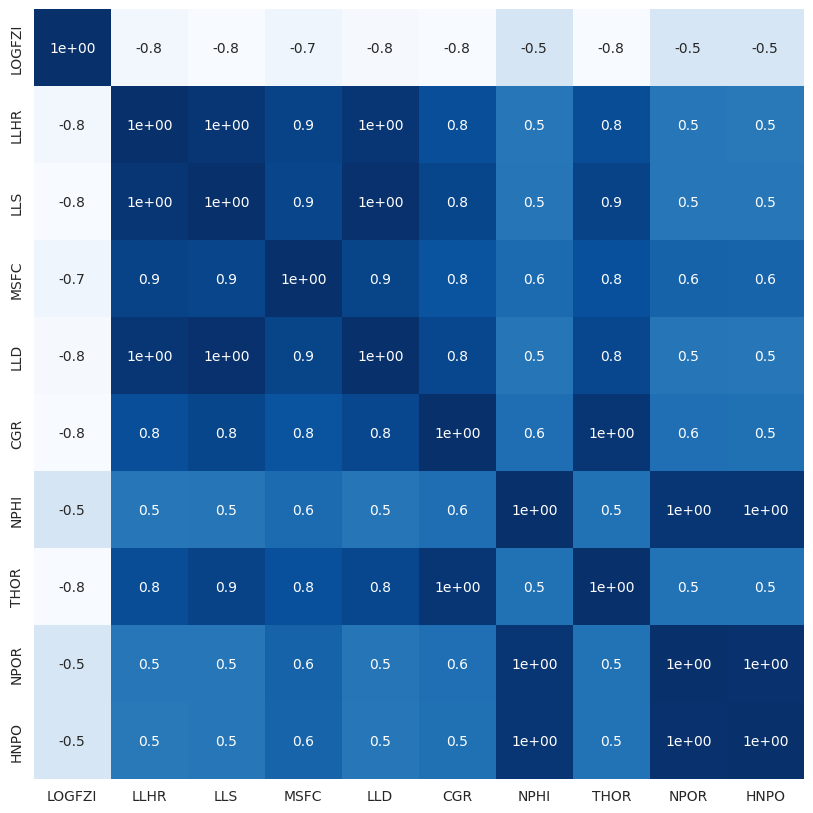

In [52]:
df2 = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/gamma_interp.csv')
#df = df.drop(columns = ['FZI'])
#X = data[['CGR', 'DRHO', 'DT5', 'GR', 'HNPO', 'LLD', 'LLHR', 'LLS', 'MRES', 'MSFC', 'NPHI', 'NPOR', 'RHOB', 'SP', 'THOR', 'URAN', 'POTA']]
df2 = df2[['LOGFZI', 'LLHR', 'LLS', 'MSFC', 'LLD', 'CGR', 'NPHI', 'THOR','NPOR','HNPO']]

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
sns.heatmap(df2.corr(), cmap= "Blues", cbar= False, annot= True, square= True, fmt= '.1')

In [53]:
X = df2.drop(columns="LOGFZI")
y = df2.LOGFZI

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((159, 9), (53, 9), (159,), (53,))

In [54]:
X_train.columns

Index(['LLHR', 'LLS', 'MSFC', 'LLD', 'CGR', 'NPHI', 'THOR', 'NPOR', 'HNPO'], dtype='object')

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 70, 'algo__max_features': 0.245099158528604, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 141}
0.9566735027637134 0.8411698279007124 0.9081113917604727


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

Training Metrics:
MSE: 0.021480989960183012
MAE: 0.1010858821664548
RMSE: 0.14656394495298974

Testing Metrics:
MSE: 0.048491611499744375
MAE: 0.1707104467828055
RMSE: 0.22020810952311537


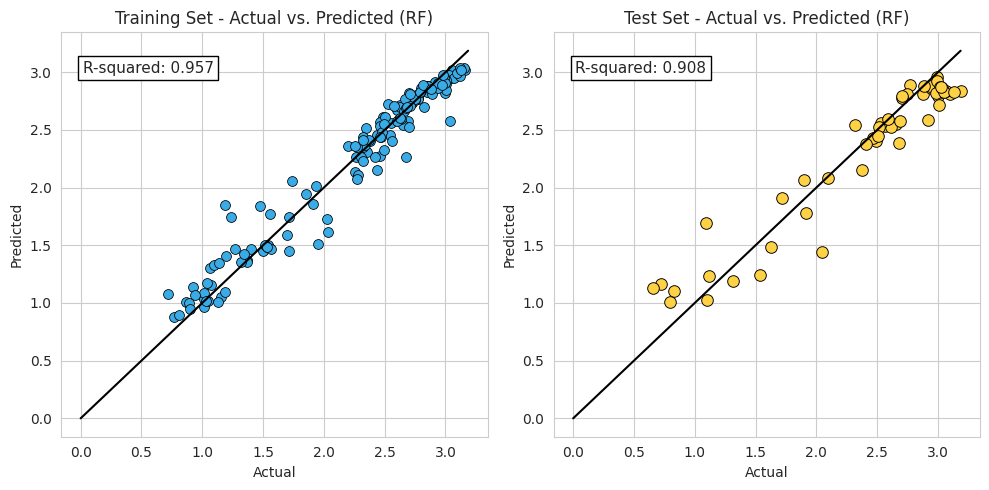

In [64]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/RF_NEW.png', dpi=300)
plt.show()

In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), X.columns )])


from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model_XGB = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGB.fit(X_train, y_train)

print(model_XGB.best_params_)
print(model_XGB.score(X_train, y_train), model_XGB.best_score_, model_XGB.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6918516030703091, 'algo__gamma': 1, 'algo__learning_rate': 0.1216411342539395, 'algo__max_depth': 3, 'algo__n_estimators': 185, 'algo__reg_alpha': 0.011502956321912733, 'algo__reg_lambda': 0.009461469059966103, 'algo__subsample': 0.7865052773762229}
0.8836637817320323 0.801785483521626 0.859327796404414


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

Training Metrics:
MSE: 0.05767872539963624
MAE: 0.1855600630972037
RMSE: 0.24016395524648623

Testing Metrics:
MSE: 0.07423577281515252
MAE: 0.21927881168278182
RMSE: 0.2724624245931033


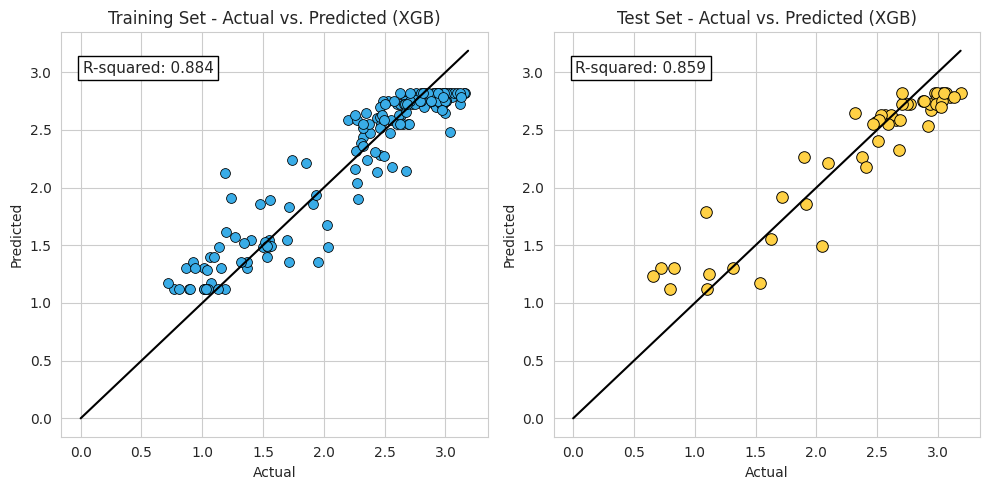

In [65]:
# Predict on training and test sets
y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (XGB)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (XGB)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/XGB_NEW.png', dpi=300)
plt.show()

In [13]:
from sklearn.svm import SVR
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), X.columns )])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model_SVM = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_SVM.fit(X_train, y_train)

print(model_SVM.best_params_)
print(model_SVM.score(X_train, y_train), model_SVM.best_score_, model_SVM.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 12.746711578215054, 'algo__gamma': 0.4374364439939081}
0.8915659566382403 0.8405557065188057 0.8946644542604792


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_SVM.predict(X_train)
y_test_pred = model_SVM.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

Training Metrics:
MSE: 0.053760879493512576
MAE: 0.16444915658540463
RMSE: 0.23186392451934512

Testing Metrics:
MSE: 0.05558785206322404
MAE: 0.1899070986932937
RMSE: 0.2357707616801202


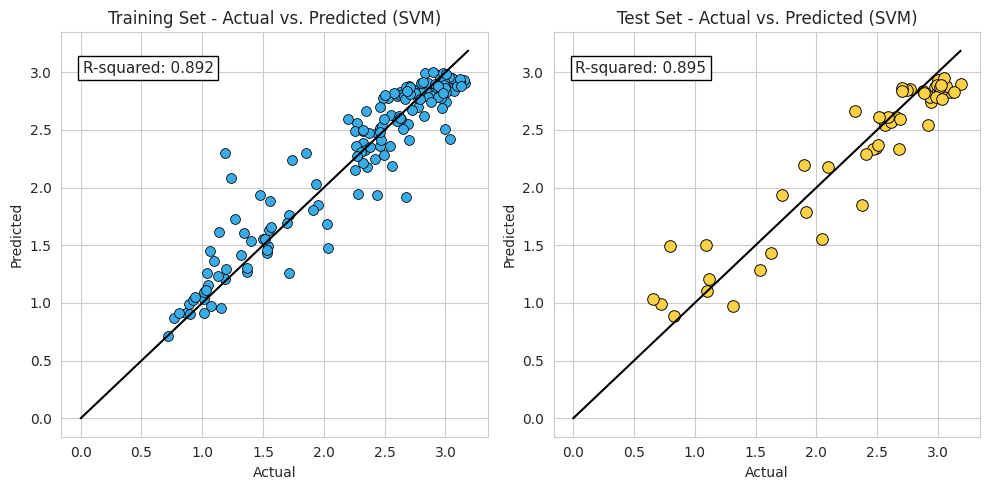

In [66]:
# Predict on training and test sets
y_train_pred = model_SVM.predict(X_train)
y_test_pred = model_SVM.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (SVM)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (SVM)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/SVR_NEW.png', dpi=300)
plt.show()

In [15]:
from sklearn.neural_network import MLPRegressor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', transform= 'yeo-johnson'), X.columns )])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(random_state=42))
])

parameter = {
    "mlp__alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    "mlp__hidden_layer_sizes": [(16, 8, 4), (16, 4), (8, 4), (13, 8, 2), (32, 16, 2), (64, 32, 16, 8, 4, 2)],
    "mlp__learning_rate_init": [0.001, 0.005, 0.01],
    "mlp__activation": ["identity"]
}

model_ANN = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_ANN.fit(X_train, y_train)

print(model_ANN.best_params_)
print(model_ANN.score(X_train, y_train), model_ANN.best_score_, model_ANN.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (64, 32, 16, 8, 4, 2), 'mlp__alpha': 0.0003, 'mlp__activation': 'identity'}
0.8181604863495389 0.7958214038966887 0.8674316978562693


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predicting the values using the trained model
y_train_pred = model_ANN.predict(X_train)
y_test_pred = model_ANN.predict(X_test)

# Calculating MSE, MAE, and RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculating MSE, MAE, and RMSE for the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Training Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

print("\nTesting Metrics:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("RMSE:", rmse_test)

Training Metrics:
MSE: 0.0901548247897295
MAE: 0.22880923828590863
RMSE: 0.30025793043603277

Testing Metrics:
MSE: 0.06995916825704215
MAE: 0.21618125477050645
RMSE: 0.2644979551093773


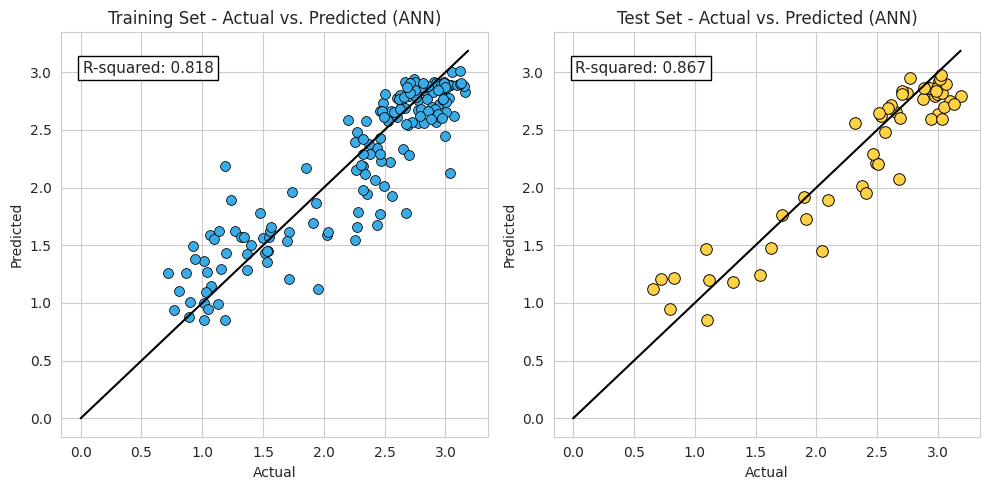

In [67]:
# Predict on training and test sets
y_train_pred = model_ANN.predict(X_train)
y_test_pred = model_ANN.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (ANN)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (ANN)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/ANN_NEW.png', dpi=300)
plt.show()

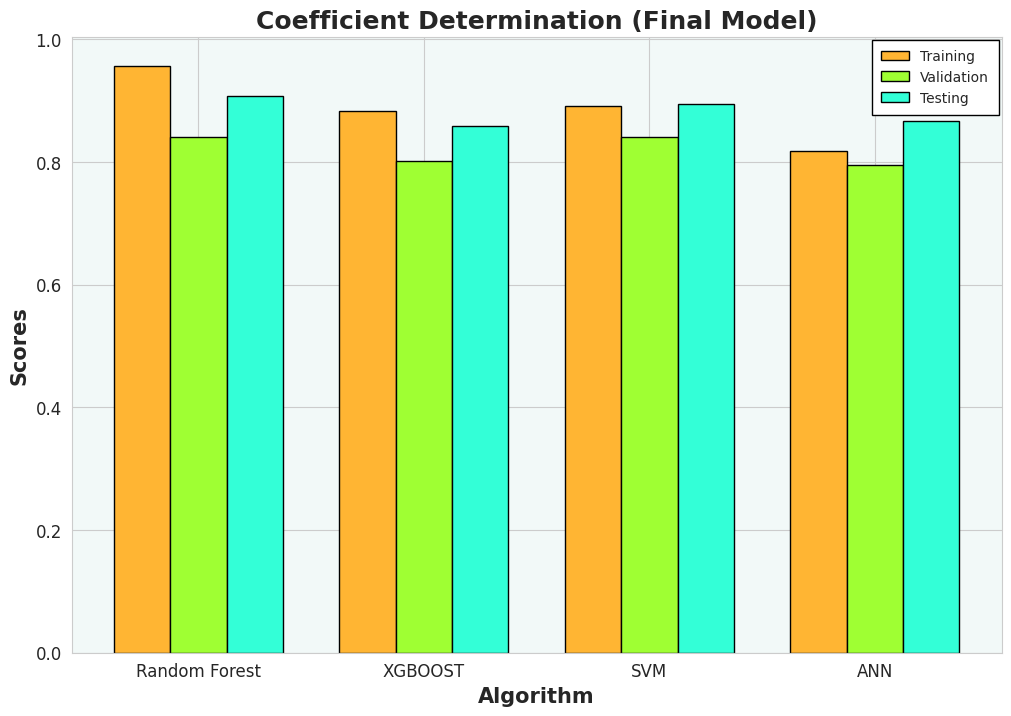

In [77]:
# Corrected code with added background color and font size adjustments

# Data provided
data = {
    "Algorithm": ["Random Forest", "XGBOOST", "SVM", "ANN"],
    "Training": [0.9566, 0.8836, 0.8915, 0.8181],
    "Validation": [0.8411, 0.8017, 0.8405, 0.7958],
    "Testing": [0.9081, 0.8593, 0.8946, 0.8674]
}

# Creating a DataFrame from the provided data
df = pd.DataFrame(data)

# Set the width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(df['Training']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the figure and the bars for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(r1, df['Training'], color='#FFB533', width=bar_width, edgecolor='black', label='Training')
ax.bar(r2, df['Validation'], color='#9FFF33', width=bar_width, edgecolor='black', label='Validation')
ax.bar(r3, df['Testing'], color='#33FFD7', width=bar_width, edgecolor='black', label='Testing')

# Adding labels and title to the plot
ax.set_xlabel('Algorithm', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(df['Training']))])
ax.set_xticklabels(df['Algorithm'], fontsize=12)
ax.set_ylabel('Scores', fontsize=15, fontweight='bold')
ax.set_title('Coefficient Determination (Final Model)', fontweight='bold', fontsize=18)



# Customize the tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a background color to the plot
ax.set_facecolor('#F2F9F8')

# Adding the legend with white background
legend = ax.legend()
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/R2_After Features Importance_.png', dpi=600)
plt.show()

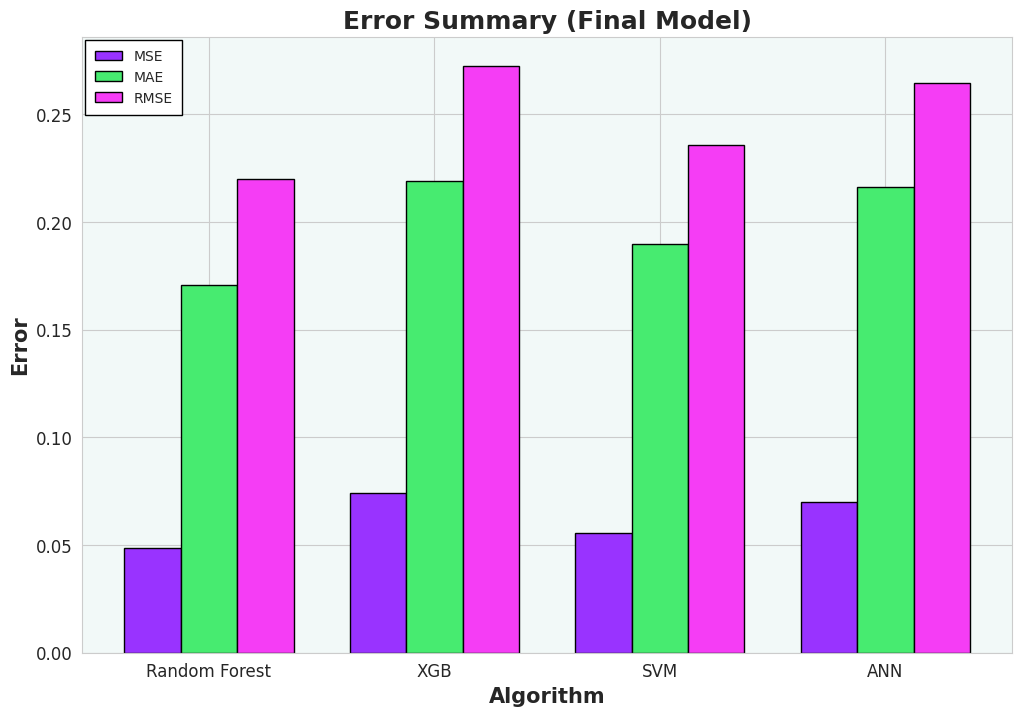

In [78]:
# Corrected code using the new data provided for MSE, MAE, and RMSE

# New data provided
new_data = {
    "Algorithm": ["Random Forest", "XGB", "SVM", "ANN"],
    "MSE": [0.048491611499744375, 0.07423577281515252, 0.05558785206322404, 0.06995916825704215],
    "MAE": [0.1707104467828055, 0.21927881168278182, 0.1899070986932937, 0.21618125477050645],
    "RMSE": [0.22020810952311537, 0.2724624245931033, 0.2357707616801202, 0.2644979551093773]
}


# Creating a DataFrame from the new data
new_df = pd.DataFrame(new_data)

# Set the width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(new_df['MSE']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the figure and the bars for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(r1, new_df['MSE'], color='#9933ff', width=bar_width, edgecolor='black', label='MSE')
ax.bar(r2, new_df['MAE'], color='#47eb70', width=bar_width, edgecolor='black', label='MAE')
ax.bar(r3, new_df['RMSE'], color='#f53df5', width=bar_width, edgecolor='black', label='RMSE')

# Adding labels and title to the plot
ax.set_xlabel('Algorithm', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(new_df['MSE']))])
ax.set_xticklabels(new_df['Algorithm'], fontsize=12)
ax.set_ylabel('Error', fontweight='bold', fontsize=15)
ax.set_title('Error Summary (Final Model)',fontweight='bold', fontsize=18)

# Customize the tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a background color to the plot
ax.set_facecolor('#F2F9F8')

# Adding the legend with white background
legend = ax.legend()
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Error_Final Model_.png', dpi=600)
plt.show()

_________

#SUMMARY

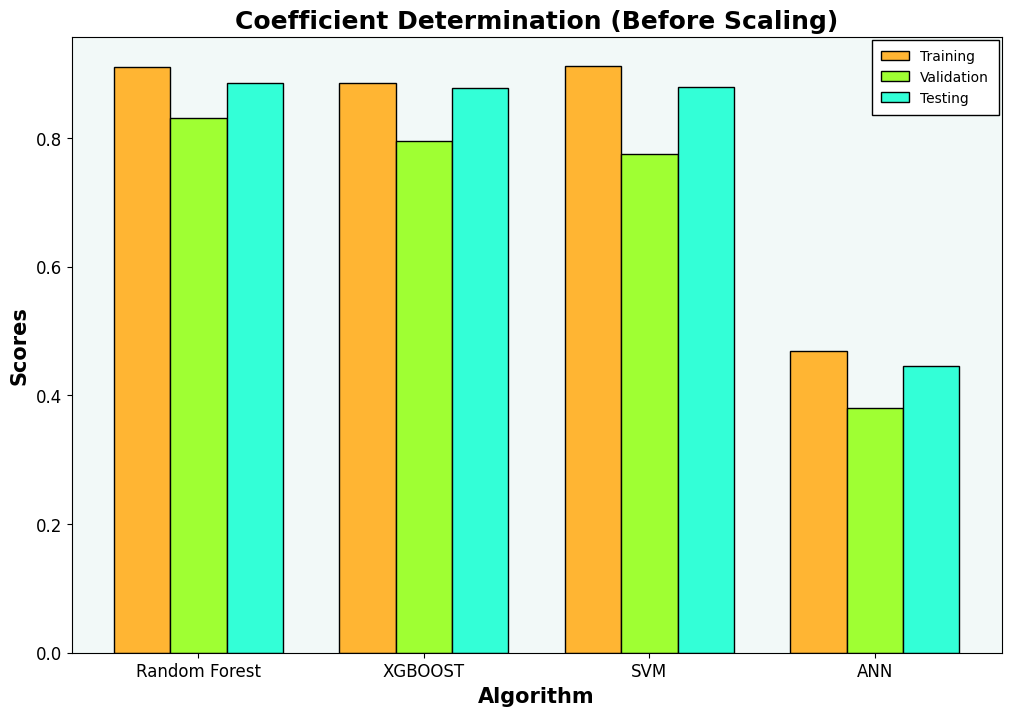

In [17]:
# Corrected code with added background color and font size adjustments

# Data provided
data = {
    "Algorithm": ["Random Forest", "XGBOOST", "SVM", "ANN"],
    "Training": [0.9106, 0.886, 0.912, 0.469],
    "Validation": [0.831, 0.796, 0.775, 0.3805],
    "Testing": [0.8850, 0.8780, 0.8800, 0.4458]
}

# Creating a DataFrame from the provided data
df = pd.DataFrame(data)

# Set the width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(df['Training']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the figure and the bars for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(r1, df['Training'], color='#FFB533', width=bar_width, edgecolor='black', label='Training')
ax.bar(r2, df['Validation'], color='#9FFF33', width=bar_width, edgecolor='black', label='Validation')
ax.bar(r3, df['Testing'], color='#33FFD7', width=bar_width, edgecolor='black', label='Testing')

# Adding labels and title to the plot
ax.set_xlabel('Algorithm', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(df['Training']))])
ax.set_xticklabels(df['Algorithm'], fontsize=12)
ax.set_ylabel('Scores', fontsize=15, fontweight='bold')
ax.set_title('Coefficient Determination (Before Scaling)', fontweight='bold', fontsize=18)



# Customize the tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a background color to the plot
ax.set_facecolor('#F2F9F8')

# Adding the legend with white background
legend = ax.legend()
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/R2_Before_.png', dpi=600)
plt.show()

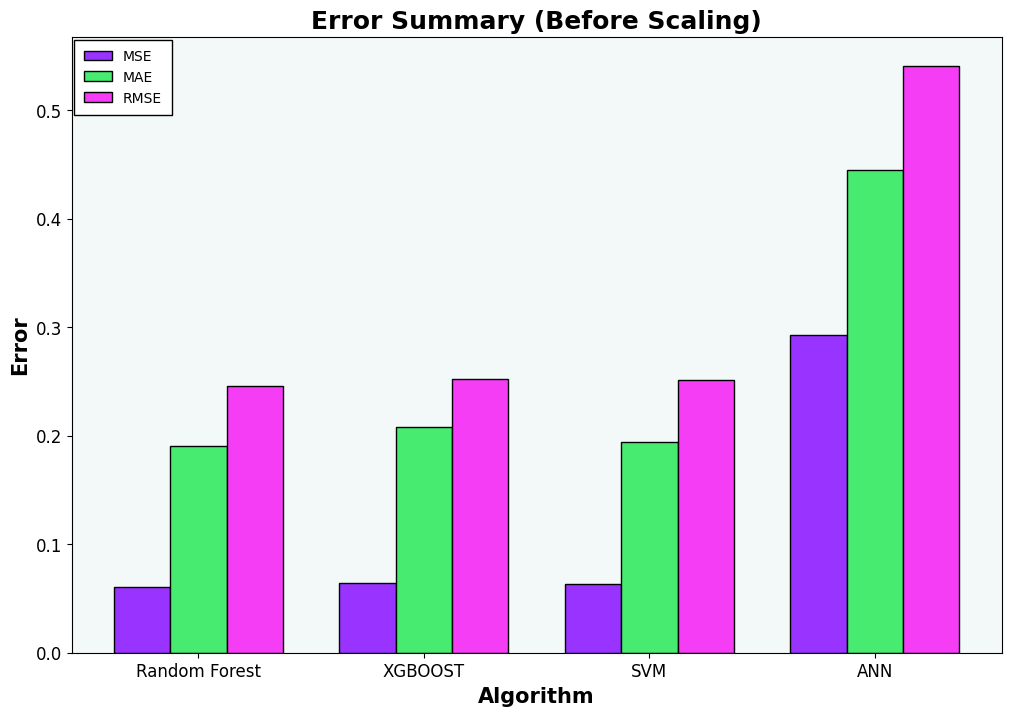

In [18]:
# Corrected code using the new data provided for MSE, MAE, and RMSE

# New data provided
new_data = {
    "Algorithm": ["Random Forest", "XGBOOST", "SVM", "ANN"],
    "MSE": [0.0604, 0.0638, 0.0629, 0.2924],
    "MAE": [0.1904, 0.2076, 0.1941, 0.4446],
    "RMSE": [0.2458, 0.2527, 0.2509, 0.5407]
}

# Creating a DataFrame from the new data
new_df = pd.DataFrame(new_data)

# Set the width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(new_df['MSE']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the figure and the bars for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(r1, new_df['MSE'], color='#9933ff', width=bar_width, edgecolor='black', label='MSE')
ax.bar(r2, new_df['MAE'], color='#47eb70', width=bar_width, edgecolor='black', label='MAE')
ax.bar(r3, new_df['RMSE'], color='#f53df5', width=bar_width, edgecolor='black', label='RMSE')

# Adding labels and title to the plot
ax.set_xlabel('Algorithm', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(new_df['MSE']))])
ax.set_xticklabels(new_df['Algorithm'], fontsize=12)
ax.set_ylabel('Error', fontweight='bold', fontsize=15)
ax.set_title('Error Summary (Before Scaling)',fontweight='bold', fontsize=18)

# Customize the tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a background color to the plot
ax.set_facecolor('#F2F9F8')

# Adding the legend with white background
legend = ax.legend()
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Error_Before_.png', dpi=600)
plt.show()

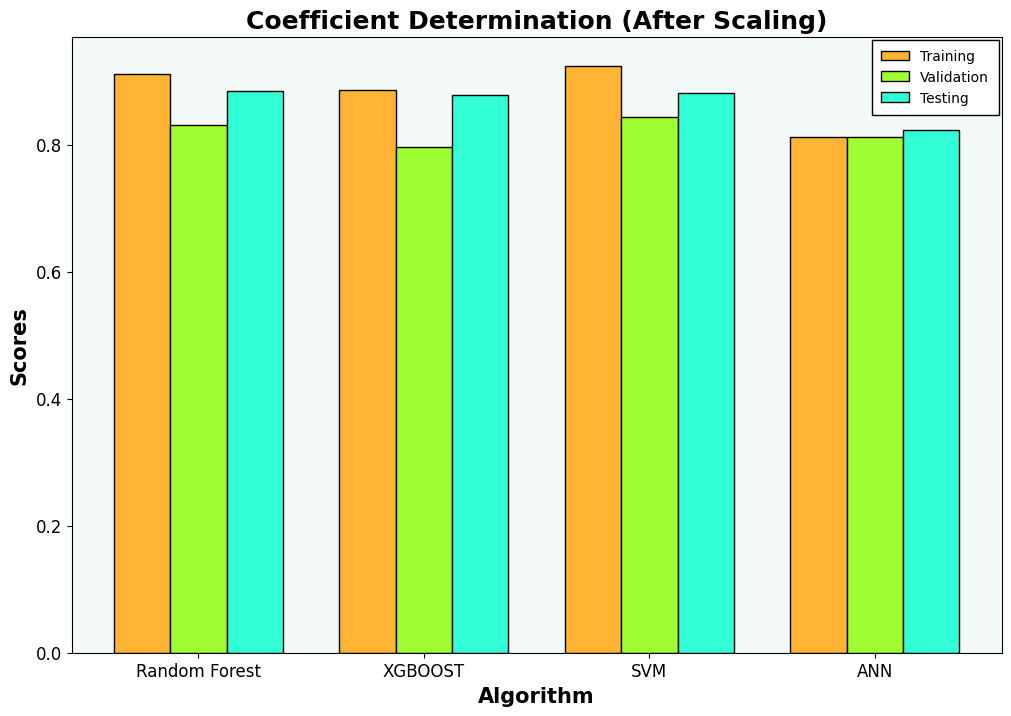

In [ ]:
# Corrected code with added background color and font size adjustments

# Data provided
data = {
    "Algorithm": ["Random Forest", "XGBOOST", "SVM", "ANN"],
    "Training": [0.9106, 0.886, 0.9238, 0.8128],
    "Validation": [0.831, 0.796, 0.844, 0.8128],
    "Testing": [0.8853, 0.8780, 0.882, 0.8235]
}

# Creating a DataFrame from the provided data
df = pd.DataFrame(data)

# Set the width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(df['Training']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the figure and the bars for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(r1, df['Training'], color='#FFB533', width=bar_width, edgecolor='black', label='Training')
ax.bar(r2, df['Validation'], color='#9FFF33', width=bar_width, edgecolor='black', label='Validation')
ax.bar(r3, df['Testing'], color='#33FFD7', width=bar_width, edgecolor='black', label='Testing')

# Adding labels and title to the plot
ax.set_xlabel('Algorithm', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(df['Training']))])
ax.set_xticklabels(df['Algorithm'], fontsize=12)
ax.set_ylabel('Scores', fontsize=15, fontweight='bold')
ax.set_title('Coefficient Determination (After Scaling)', fontweight='bold', fontsize=18)



# Customize the tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a background color to the plot
ax.set_facecolor('#F2F9F8')

# Adding the legend with white background
legend = ax.legend()
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/R2_After_.png', dpi=600)
plt.show()

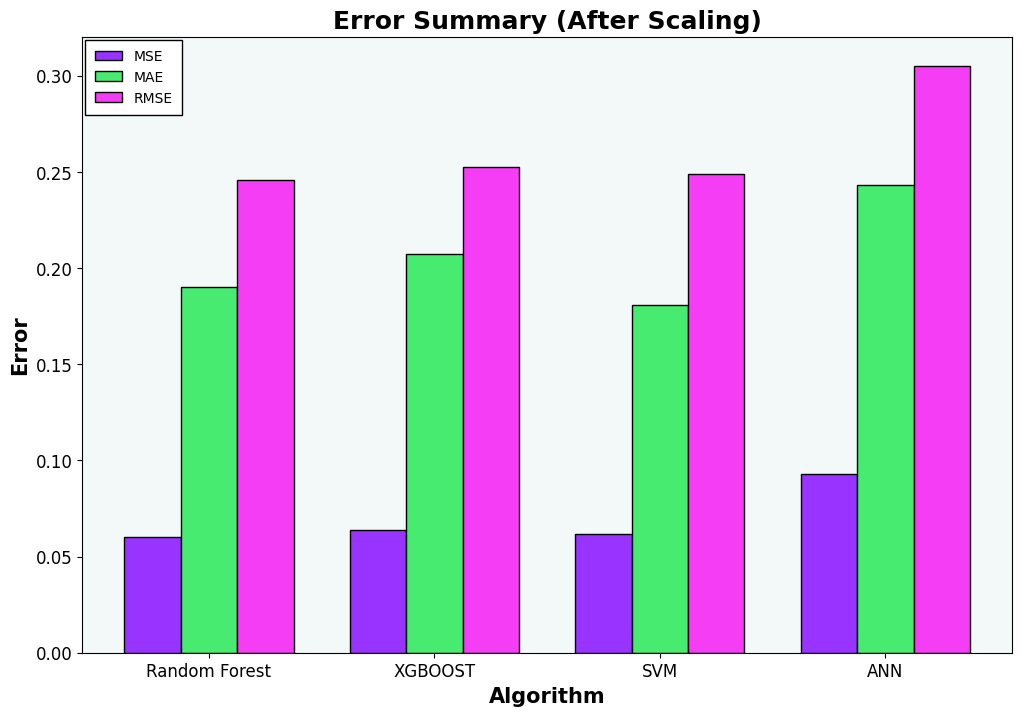

In [20]:
# Corrected code using the new data provided for MSE, MAE, and RMSE

# New data provided
new_data = {
    "Algorithm": ["Random Forest", "XGBOOST", "SVM", "ANN"],
    "MSE": [0.0604, 0.0638, 0.062, 0.0931],
    "MAE": [0.1904, 0.2076, 0.1807, 0.2433],
    "RMSE": [0.2458, 0.2527, 0.2491, 0.3051]
}

# Creating a DataFrame from the new data
new_df = pd.DataFrame(new_data)

# Set the width of each bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(new_df['MSE']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the figure and the bars for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(r1, new_df['MSE'], color='#9933ff', width=bar_width, edgecolor='black', label='MSE')
ax.bar(r2, new_df['MAE'], color='#47eb70', width=bar_width, edgecolor='black', label='MAE')
ax.bar(r3, new_df['RMSE'], color='#f53df5', width=bar_width, edgecolor='black', label='RMSE')

# Adding labels and title to the plot
ax.set_xlabel('Algorithm', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width for r in range(len(new_df['MSE']))])
ax.set_xticklabels(new_df['Algorithm'], fontsize=12)
ax.set_ylabel('Error', fontweight='bold', fontsize=15)
ax.set_title('Error Summary (After Scaling)',fontweight='bold', fontsize=18)

# Customize the tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a background color to the plot
ax.set_facecolor('#F2F9F8')

# Adding the legend with white background
legend = ax.legend()
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/After_Before_.png', dpi=600)
plt.show()

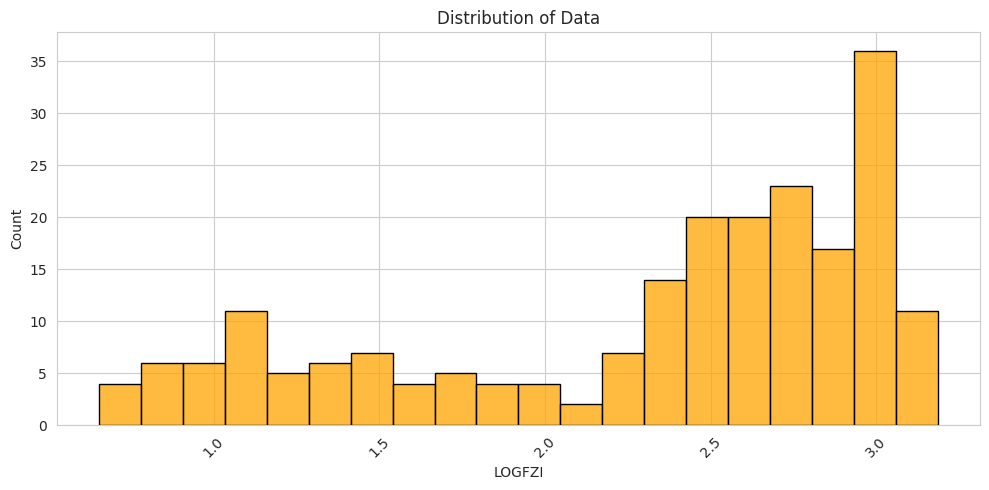

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Read data from CSV file
data = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/gamma_interp.csv')['LOGFZI']

# Plot histogram using seaborn
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data, color='orange', edgecolor='black', bins=20)

# Customize plot
plt.title('Distribution of Data')
plt.xlabel('LOGFZI')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Adjust the layout
plt.tight_layout()

# Show plot
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Distribution of data_LOGFZI.png', dpi=600)
plt.show()

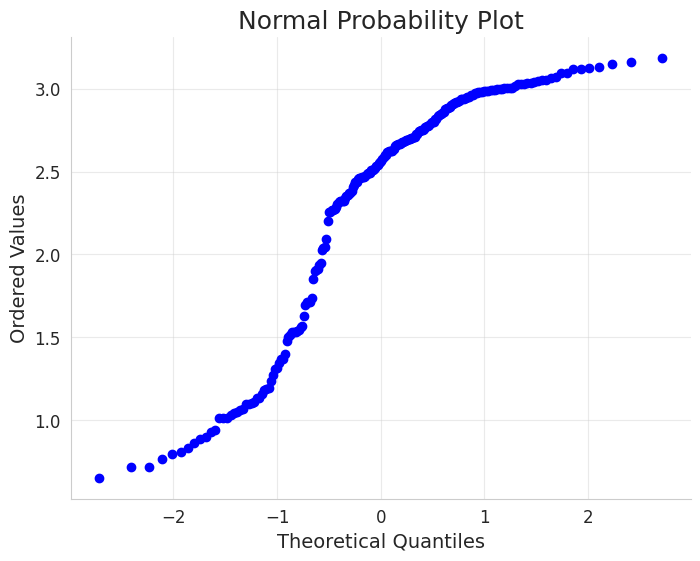

In [22]:
import numpy as np
import seaborn as sns
from scipy import stats

# Select the column to use for the normal probability plot

X = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/gamma_interp.csv')['LOGFZI'].values

# Create normal probability plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
stats.probplot(X, plot=ax, fit=False)

# Set plot title and labels
ax.set_title('Normal Probability Plot', fontsize=18)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Ordered Values', fontsize=14)

# Customize plot aesthetics
sns.despine()
ax.tick_params(labelsize=12)
ax.grid(axis='y', alpha=0.4)
ax.grid(axis='x', alpha=0.4)

# Show the plot
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Image/Normal Probability Plot_.png', dpi=600)
plt.show()

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

# Load the CSV file into a Pandas DataFrame
# Read data from CSV file
data = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Data_FZI.csv')

# Extract the 'FZI' column as the feature for clustering
X = data[['LOGFZI']]

# Specify the maximum number of clusters to evaluate
max_clusters = 15

# Initialize lists to store the results
num_clusters_list = []
rmse_list = []
r2_list = []

# Perform K-Means clustering for different number of clusters
for num_clusters in range(1, max_clusters + 1):
    # Initialize K-Means clustering algorithm
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Perform clustering
    kmeans.fit(X)

    # Calculate the centroid for each sample
    centroids = kmeans.cluster_centers_[kmeans.labels_]

    # Calculate the RMSE
    rmse_value = mean_squared_error(X, centroids, squared=False)

    # Calculate the R-squared
    r2_value = r2_score(X, centroids)

    # Append number of clusters, RMSE, and R-squared to the lists
    num_clusters_list.append(num_clusters)
    rmse_list.append(rmse_value)
    r2_list.append(r2_value)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Number of Clusters': num_clusters_list,
    'RMSE': rmse_list,
    'R-squared': r2_list
})


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

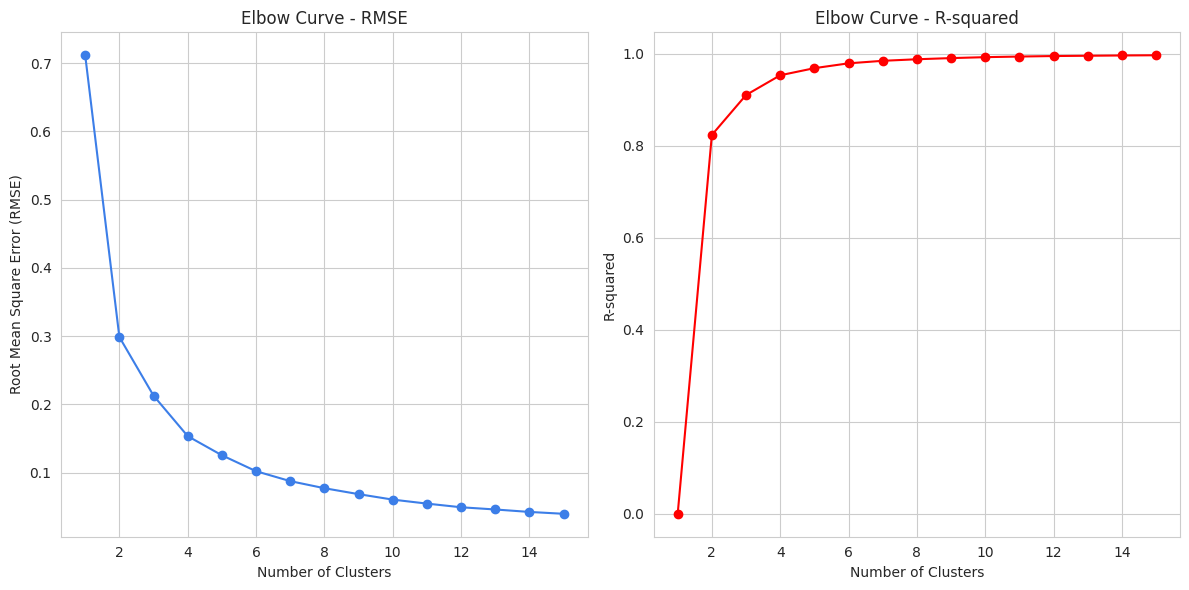

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the RMSE elbow curve
sns.set_style('whitegrid')
ax1.plot(num_clusters_list, rmse_list, marker='o', color='#3C7EE8')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Root Mean Square Error (RMSE)')
ax1.set_title('Elbow Curve - RMSE')

# Plot the R-Squared elbow curve
sns.set_style('whitegrid')
ax2.plot(num_clusters_list, r2_list, marker='o', color='#FF0000')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('R-squared')
ax2.set_title('Elbow Curve - R-squared')

# Adjust the layout and display the plot
plt.tight_layout()
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Image/Elbow Analysis.png', dpi=600)
plt.show()


In [25]:
# Save the clustered data into an Excel file
#data.to_excel('Clustered_Data.xlsx', index=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


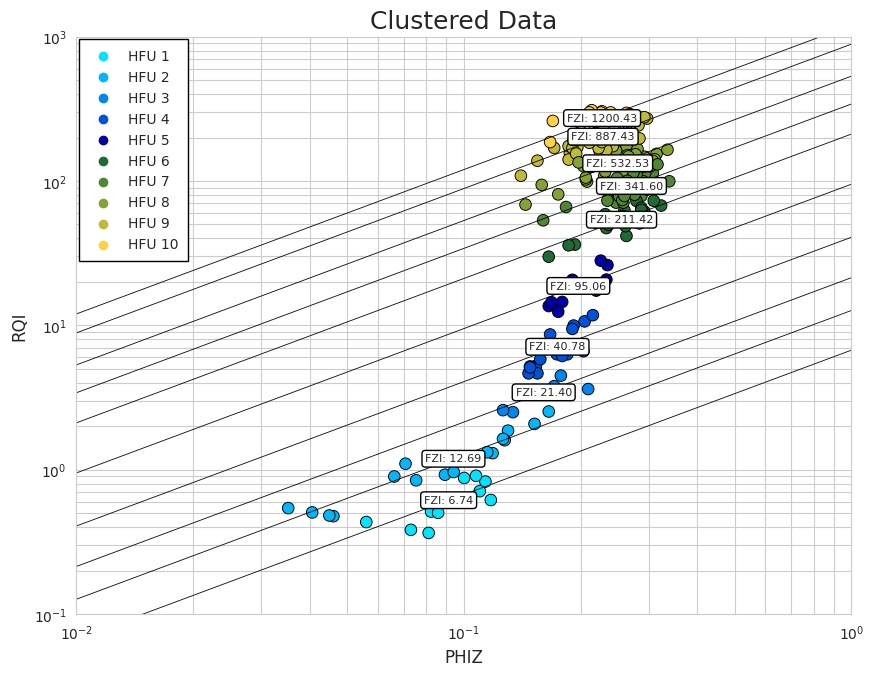

                RQI      PHIZ          FZI
Cluster                                   
HFU 1      0.615186  0.091299     6.738156
HFU 2      1.191671  0.093938    12.685708
HFU 3      3.437403  0.160611    21.402084
HFU 4      7.107769  0.174276    40.784620
HFU 5     18.757058  0.197318    95.059851
HFU 6     53.926544  0.255068   211.419878
HFU 7     92.409726  0.270521   341.599524
HFU 8    132.759414  0.249301   532.526343
HFU 9    202.758535  0.228477   887.434804
HFU 10   272.763410  0.227222  1200.429051


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the CSV file into a Pandas DataFrame
data = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Data_FZI.csv')

# Extract the 'FZI' column as the feature for clustering
X = data[['LOGFZI']]

# Perform K-Means clustering with the optimal number of clusters
optimal_num_clusters = 10  # Change this to the desired number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
kmeans.fit(X)

# Add the cluster labels to the DataFrame
data['Cluster'] = kmeans.labels_

# Define a mapping of cluster numbers to cluster names
cluster_names = {
    0: 'HFU 9',
    1: 'HFU 3',
    2: 'HFU 6',
    3: 'HFU 1',
    4: 'HFU 5',
    5: 'HFU 7',
    6: 'HFU 2',
    7: 'HFU 10',
    8: 'HFU 4',
    9: 'HFU 8',
    # Add more mappings as needed for each cluster number
}

# Map the cluster numbers to cluster names in the DataFrame
data['Cluster'] = data['Cluster'].map(cluster_names)

# Calculate the mean 'RQI' and 'PHIZ' for each cluster
cluster_means = data.groupby('Cluster')[['RQI', 'PHIZ']].mean()

# Calculate the FZI (RQI divided by PHIZ)
cluster_means['FZI'] = cluster_means['RQI'] / cluster_means['PHIZ']

# Sort the cluster means by FZI in ascending order
cluster_means = cluster_means.sort_values('FZI')

# Get the sorted cluster labels
sorted_cluster_labels = cluster_means.index.tolist()

# Define a custom color palette for the clusters
cluster_colors = ['#00e4ff', '#00b7fb', '#0086f2', '#0052d8', '#0000a5', '#206a33', '#518635', '#85a235', '#bfbb38', '#ffd145']  # Change the colors as desired

# Plot the clustered data with the custom color palette and updated cluster labels
# Set the figure size
plt.figure(figsize=(10, 7.5))
sns.scatterplot(data=data, x='PHIZ', y='RQI', hue='Cluster', s=70, palette=cluster_colors, hue_order=sorted_cluster_labels, edgecolor='black')
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which="both", ls="-")
plt.xlabel('PHIZ', fontsize=12)
plt.ylabel('RQI', fontsize=12)
plt.title('Clustered Data', fontsize=18)

# Plot the straight lines in each centroid
for cluster in cluster_means.index:
    centroid = cluster_means.loc[cluster]
    x = np.linspace(0.001, 100, num=100) * centroid['PHIZ']  # Adjusted x-values
    y = np.linspace(0.001, 100, num=100) * centroid['RQI']  # Adjusted y-values
    plt.plot(x, y, color='black', linestyle='-', linewidth=0.65,  alpha=0.91)

    # Add FZI value to the cluster
    text_x = centroid['PHIZ']  # x-coordinate for the text
    text_y = centroid['RQI']  # y-coordinate for the text
    fzi_value = cluster_means.loc[cluster, 'FZI']  # FZI value for the cluster
    plt.text(text_x, text_y, f'FZI: {fzi_value:.2f}', fontsize=8, ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Limit the x-axis range
plt.xlim(0.01, 1)
plt.ylim(0.1, 1000)

# Display the plot
legend = plt.legend()
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Cluster.png', dpi=600)
plt.show()

# Display the mean values and FZI in the new order
print(cluster_means)

In [27]:

# Save the clustered data into an Excel file
#data.to_excel('Clustered_Data_2.xlsx', index=True)


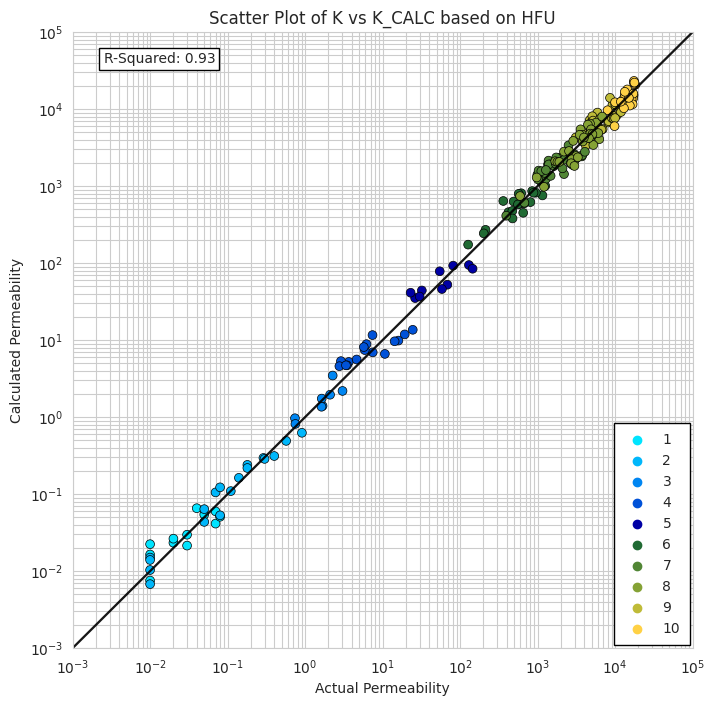

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/KPred.csv')

# Define a custom color palette for the clusters
colors = {1:'#00e4ff', 2:'#00b7fb', 3:'#0086f2', 4:'#0052d8', 5:'#0000a5', 6:'#206a33', 7:'#518635', 8:'#85a235', 9:'#bfbb38', 10:'#ffd145'}  # Change the colors as desired

# Create the scatter plot using seaborn
# Create the scatter plot using seaborn
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x='K', y='K_CALC', hue='HFU', palette=colors, s=40, edgecolor='black')

# Add labels and title to the plot
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Actual Permeability')
plt.ylabel('Calculated Permeability')
plt.title('Scatter Plot of K vs K_CALC based on HFU')

# Perform linear regression
x = df['K']
y = df['K_CALC']
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)
y_fit = poly(x)

# Calculate R-squared value
residuals = y - y_fit
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_residuals / ss_total)

# Plot the fitted line
x1 = np.linspace(0.001, 100000, num=100)  # Adjusted x-values
y1 = np.linspace(0.001, 100000, num=100) # Adjusted y-values
plt.plot(x1, y1, color='black', linestyle='-', linewidth=1.65,  alpha=0.91)

# Limit the x-axis range
plt.xlim(0.001, 100000)
plt.ylim(0.001, 100000)

# Display the R-squared value in the plot
textbox_props = dict(boxstyle='square', facecolor='white', edgecolor='black')
plt.text(0.05, 0.95, f'R-Squared: {r_squared:.2f}', transform=plt.gca().transAxes, bbox=textbox_props)


# Display the plot
# Move the legend to the bottom-right corner
# Move the legend to the bottom-right corner
legend = plt.legend(loc='lower right')

# Set legend properties for background color and edge color
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle('square')
plt.grid(True, which="both", ls="-")
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Scatter plot K.png', dpi=600)
plt.show()


In [29]:
import pandas as pd
from scipy.stats import hmean, gmean

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/KPred.csv')

# Calculate the means and number of samples
mean_phi = df.groupby('HFU')['PHI'].mean().round(3)
mean_k_calc = df.groupby('HFU')['K_CALC'].mean().round(3)
harmonic_k_calc = df.groupby('HFU')['K_CALC'].apply(hmean).round(3)
geometric_k_calc = df.groupby('HFU')['K_CALC'].apply(gmean).round(3)
num_samples = df['HFU'].value_counts()

# Create a new DataFrame to store the means
mean_table = pd.DataFrame({
    'Mean PHI': mean_phi,
    'Mean K_CALC': mean_k_calc,
    'Harmonic K_CALC': harmonic_k_calc,
    'Geometric K_CALC': geometric_k_calc,
    'Number of Samples': num_samples
})

# Display the mean table
mean_table


,Mean PHI,Mean K_CALC,Harmonic K_CALC,Geometric K_CALC,Number of Samples
1,0.083,0.035,0.024,0.030,12
2,0.085,0.176,0.036,0.092,18
3,0.138,1.737,1.444,1.580,8
4,0.148,7.797,6.911,7.331,16
5,0.164,60.609,52.854,56.493,10
6,0.202,624.634,502.052,568.510,21
7,0.212,1890.420,1582.707,1765.872,31
8,0.198,3794.595,2806.699,3334.136,35
9,0.185,8184.655,6410.074,7314.078,40
10,0.185,14299.726,12511.899,13446.555,21


<ipython-input-90-2a5fbc05c321>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsampled_data['DEPTH'] = unsampled_features['DEPTH']  # Add DEPTH column to unsampled_data
<ipython-input-90-2a5fbc05c321>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsampled_data['Predicted_RF'] = unsampled_predictions_RF
<ipython-input-90-2a5fbc05c321>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

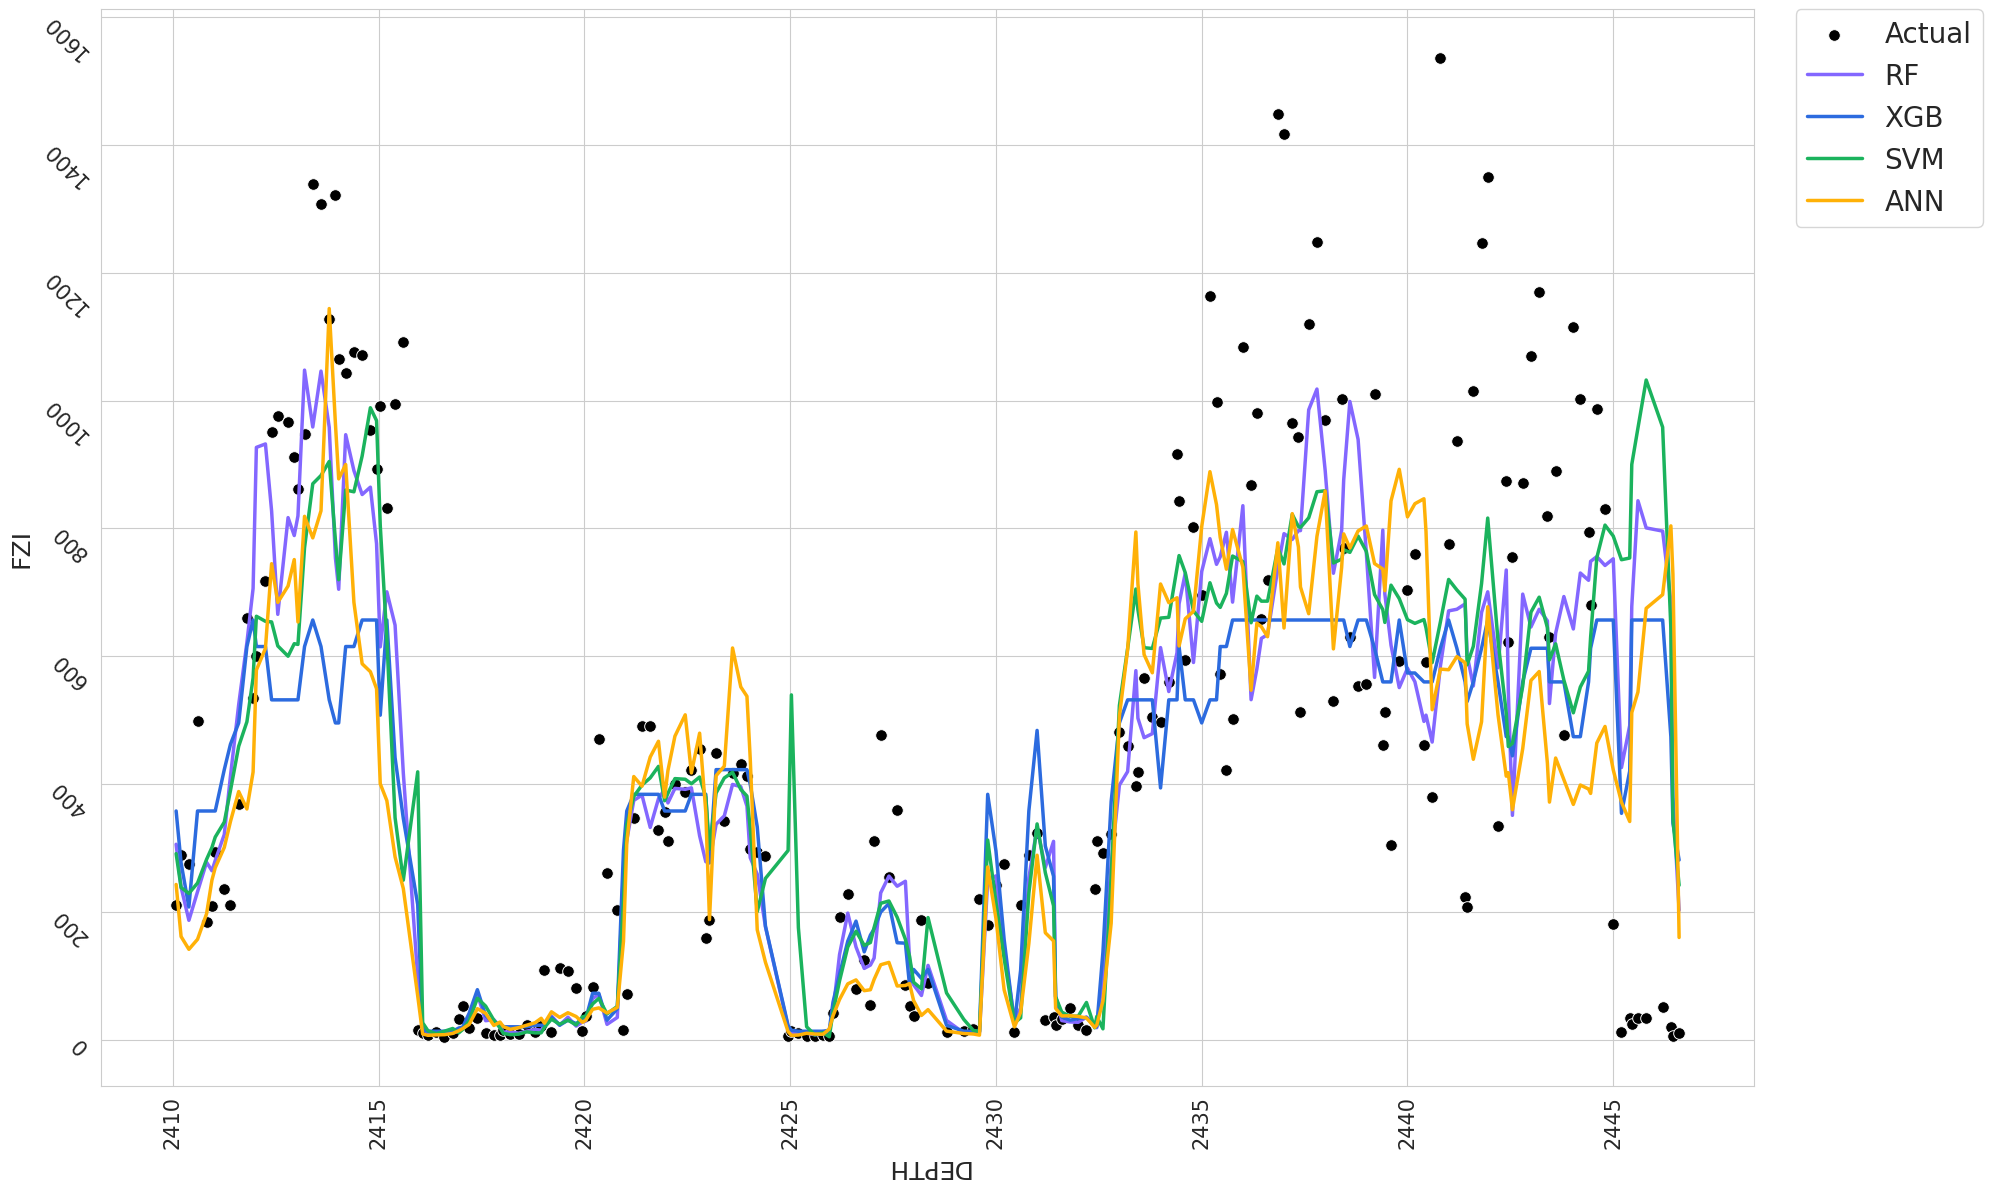

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset with the actual feature values for the unsampled location
unsampled_features = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/datatest1.csv')
df3 = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/datatest0.csv')

# Prepare the input data for prediction
unsampled_data = unsampled_features[['LLHR', 'LLS', 'MSFC', 'LLD', 'CGR', 'NPHI', 'THOR', 'NPOR', 'HNPO']]
unsampled_data['DEPTH'] = unsampled_features['DEPTH']  # Add DEPTH column to unsampled_data

# Use the trained models to make predictions
unsampled_predictions_RF = model_RF.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_XGB = model_XGB.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_SVM = model_SVM.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_ANN = model_ANN.predict(unsampled_data.drop('DEPTH', axis=1))

# Apply back transformation to FZI values for each model's predictions
unsampled_predictions_RF = 10 ** (unsampled_predictions_RF)
unsampled_predictions_XGB = 10 ** (unsampled_predictions_XGB)
unsampled_predictions_SVM = 10 ** (unsampled_predictions_SVM)
unsampled_predictions_ANN = 10 ** (unsampled_predictions_ANN)

# Create separate columns for each model's predictions in the unsampled_data DataFrame
unsampled_data['Predicted_RF'] = unsampled_predictions_RF
unsampled_data['Predicted_XGB'] = unsampled_predictions_XGB
unsampled_data['Predicted_SVM'] = unsampled_predictions_SVM
unsampled_data['Predicted_ANN'] = unsampled_predictions_ANN

# Define the colors for scatter plots and lines
colorsz = ['#8367FF', '#2C6BDF', '#1BB35D', '#FFB107']

# Plot the actual and predicted values using seaborn
fig, ax = plt.subplots(figsize=(20, 12))
sns.scatterplot(data=df3, x='DEPTH', y='FZI', color='black', label='Actual', marker='o', s=70)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_RF', color=colorsz[0], label='RF', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_XGB', color=colorsz[1], label='XGB', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_SVM', color=colorsz[2], label='SVM', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_ANN', color=colorsz[3], label='ANN', linewidth=2.5)

plt.xlabel('DEPTH', rotation=180, fontsize=18)
plt.ylabel('FZI', fontsize=18)
legend = plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1), ncol=1, borderaxespad=0, fontsize=20)
plt.setp(legend.get_title(), rotation=-90, fontsize=18)

# Rotate x-axis label
plt.xticks(rotation=90, fontsize=15)  # Rotates x-axis labels by 90 degrees clockwise
plt.yticks(rotation=135, fontsize=15)

# Adjust the layout
plt.tight_layout()

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/permeability prediction by depth.png', dpi=600)
plt.show()

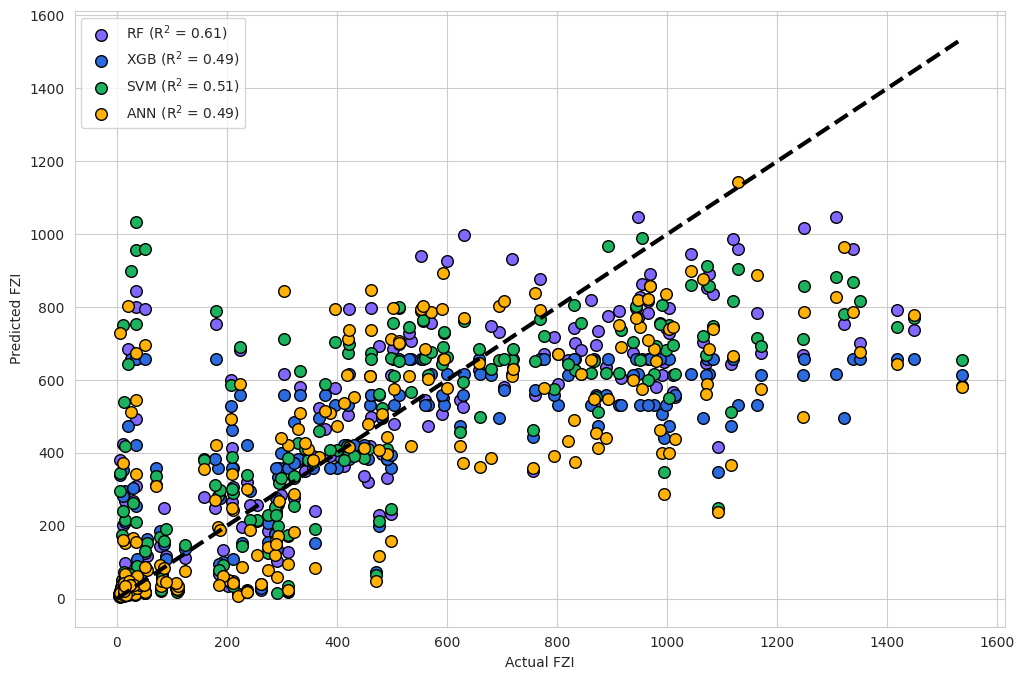

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming df3 and unsampled_data are already defined and loaded

# Find the maximum actual and predicted values
max_value = max(df3['FZI'].max(), unsampled_data['Predicted_RF'].max(),
                unsampled_data['Predicted_XGB'].max(), unsampled_data['Predicted_SVM'].max(),
                unsampled_data['Predicted_ANN'].max())

# Calculate R-squared values for each model
r2_RF = r2_score(df3['FZI'], unsampled_data['Predicted_RF'])
r2_XGB = r2_score(df3['FZI'], unsampled_data['Predicted_XGB'])
r2_SVM = r2_score(df3['FZI'], unsampled_data['Predicted_SVM'])
r2_ANN = r2_score(df3['FZI'], unsampled_data['Predicted_ANN'])

# Plot the 1:1 line and R-squared values for all models
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([0, max_value], [0, max_value], color='black', linestyle='--', linewidth = 3)

# Define the colors for scatter plots and lines
colorsz = ['#8367FF', '#2C6BDF', '#1BB35D', '#FFB107']

# Scatter plots
ax.scatter(df3['FZI'], unsampled_data['Predicted_RF'], color=colorsz[0], label=f'RF (R$^2$ = {r2_RF:.2f})', s = 70, edgecolor='black')
ax.scatter(df3['FZI'], unsampled_data['Predicted_XGB'], color=colorsz[1],label=f'XGB (R$^2$ = {r2_XGB:.2f})', s = 70, edgecolor='black')
ax.scatter(df3['FZI'], unsampled_data['Predicted_SVM'], color=colorsz[2],label=f'SVM (R$^2$ = {r2_SVM:.2f})', s = 70, edgecolor='black')
ax.scatter(df3['FZI'], unsampled_data['Predicted_ANN'], color=colorsz[3],label=f'ANN (R$^2$ = {r2_ANN:.2f})', s = 70, edgecolor='black')

ax.set_xlabel('Actual FZI')
ax.set_ylabel('Predicted FZI')
ax.legend()

# Save the figure
fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/FZI_Prediction_Unsample_Location.png', dpi=600)

# Show the plot
plt.show()

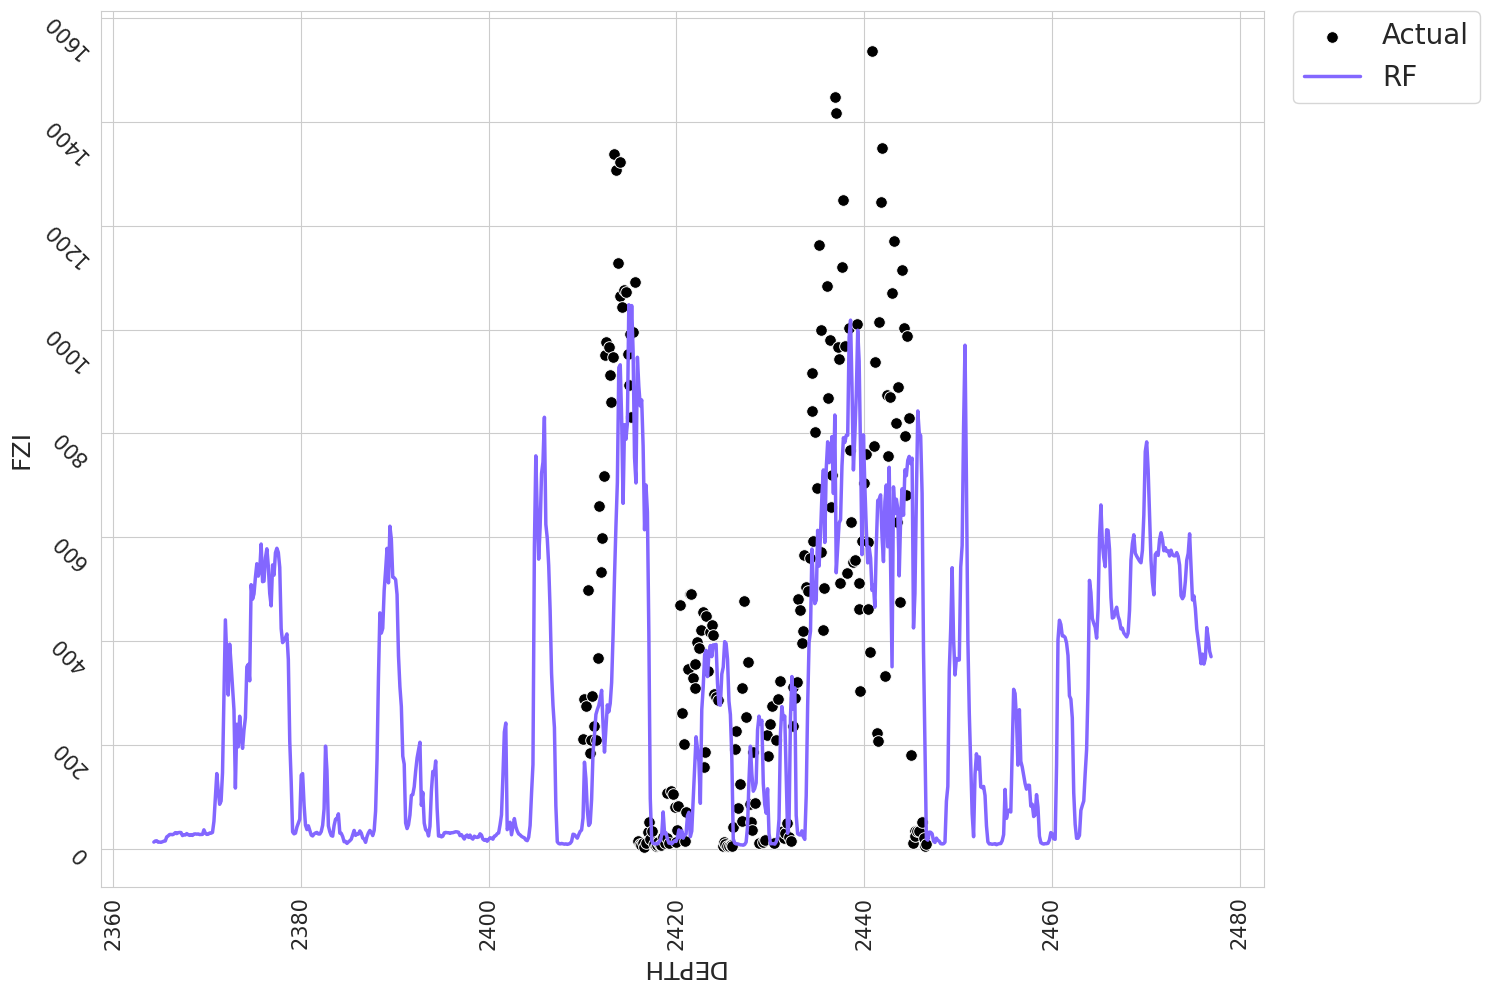

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset with the actual feature values for the unsampled location

# Load the dataset with the actual feature values for the unsampled location
unsampled_features = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/datatest2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/datatest0.csv')


# Prepare the input data for prediction
unsampled_data = unsampled_features[['LLHR', 'LLS', 'MSFC', 'LLD', 'CGR', 'NPHI', 'THOR', 'NPOR', 'HNPO']]
unsampled_data['DEPTH'] = unsampled_features['DEPTH']  # Add DEPTH column to unsampled_data

# Use the trained models to make predictions
unsampled_predictions_RF = model_RF.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_XGB = model_XGB.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_SVM = model_SVM.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_ANN = model_ANN.predict(unsampled_data.drop('DEPTH', axis=1))

# Apply back transformation to FZI values for each model's predictions
unsampled_predictions_RF = 10 ** (unsampled_predictions_RF)
unsampled_predictions_XGB = 10 ** (unsampled_predictions_XGB)
unsampled_predictions_SVM = 10 ** (unsampled_predictions_SVM)
unsampled_predictions_ANN = 10 ** (unsampled_predictions_ANN)

# Create separate columns for each model's predictions in the unsampled_data DataFrame
unsampled_data['Predicted_RF'] = unsampled_predictions_RF
unsampled_data['Predicted_XGB'] = unsampled_predictions_XGB
unsampled_data['Predicted_SVM'] = unsampled_predictions_SVM
unsampled_data['Predicted_ANN'] = unsampled_predictions_ANN

# Define the colors for scatter plots and lines
colorsz = ['#8367FF', '#2C6BDF', '#1BB35D', '#FFB107']

# Plot the actual and predicted values using seaborn

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df3, x='DEPTH', y='FZI', color='black', label='Actual', marker='o', s=70)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_RF', color=colorsz[0], label='RF', linewidth=2.5)
#sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_XGB', color=colorsz[1], label='XGB', linewidth=2.5)
#sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_SVM', color=colorsz[2], label='SVM', linewidth=2.5)
#sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_ANN', color=colorsz[3], label='ANN', linewidth=2.5)

plt.xlabel('DEPTH', rotation=180, fontsize=18)
plt.ylabel('FZI', fontsize=18)
legend = plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1), ncol=1, borderaxespad=0, fontsize=20)
plt.setp(legend.get_title(), rotation=-90, fontsize=18)

# Rotate x-axis label
plt.xticks(rotation=90, fontsize=15)  # Rotates x-axis labels by 90 degrees clockwise
plt.yticks(rotation=135, fontsize=15)

# Adjust the layout
plt.tight_layout()

fig.savefig('/content/drive/MyDrive/01_Project_Reservoir_Description/Figures/Blind_Data.png', dpi=600)
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate the RMSE
rmse = sqrt(mean_squared_error(df3['FZI'], unsampled_data['Predicted']))

# Create a DataFrame to store the error values
error_data = pd.DataFrame({'Actual FZI': df3['FZI'], 'Predicted FZI': unsampled_data['Predicted']})
error_data['Error'] = error_data['Actual FZI'] - error_data['Predicted FZI']

# Save the error data to an Excel file
error_data.to_excel('error_analysis.xlsx', index=False)


KeyError: ignored

In [ ]:
import pandas as pd

# Read the datasets
merge1 = pd.read_csv('merge1.csv')
merge2 = pd.read_csv('merge2.csv')

merge1['FZI'] = np.interp(merge1['DEPTH'], merge2['DEPTH'], merge2['FZI'])

merge1

# Save the updated merge1 dataset
merge1.to_csv('updated_merge1.csv', index=False)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset with the actual feature values for the unsampled location
unsampled_features = pd.read_csv('datatest1.csv')
df3 = pd.read_csv('datatest0.csv')

# Prepare the input data for prediction
unsampled_data = unsampled_features[['LLHR', 'LLS', 'MSFC', 'LLD', 'CGR', 'NPHI', 'THOR', 'NPOR', 'HNPO']]
unsampled_data['DEPTH'] = unsampled_features['DEPTH']  # Add DEPTH column to unsampled_data

# Use the trained models to make predictions
unsampled_predictions_RF = model_RF.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_XGB = model_XGB.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_SVM = model_SVM.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_ANN = model_ANN.predict(unsampled_data.drop('DEPTH', axis=1))

# Apply back transformation to FZI values for each model's predictions
unsampled_predictions_RF = (unsampled_predictions_RF)
unsampled_predictions_XGB = (unsampled_predictions_XGB)
unsampled_predictions_SVM = (unsampled_predictions_SVM)
unsampled_predictions_ANN = (unsampled_predictions_ANN)

# Create separate columns for each model's predictions in the unsampled_data DataFrame
unsampled_data['Predicted_RF'] = unsampled_predictions_RF
unsampled_data['Predicted_XGB'] = unsampled_predictions_XGB
unsampled_data['Predicted_SVM'] = unsampled_predictions_SVM
unsampled_data['Predicted_ANN'] = unsampled_predictions_ANN

# Plot the actual and predicted values using seaborn
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df3, x='DEPTH', y='LOGFZI', color='#add8e6', label='Actual', marker='o', s=80, edgecolor='black')
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_RF', color='red', label='RF', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_XGB', color='blue', label='XGB', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_SVM', color='green', label='SVM', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_ANN', color='orange', label='ANN', linewidth=2.5)

plt.xlabel('DEPTH')
legend = plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1), ncol=1, borderaxespad=0)
plt.setp(legend.get_title(), rotation=-90)  # Rotate the legend title
plt.title('Actual vs. Predicted (Unsampled) FZI Values')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset with the actual feature values for the unsampled location
unsampled_features = pd.read_csv('datatest2.csv')
df3 = pd.read_csv('datatest0.csv')

# Prepare the input data for prediction
unsampled_data = unsampled_features[['LLHR', 'LLS', 'MSFC', 'LLD', 'CGR', 'NPHI', 'THOR', 'NPOR', 'HNPO']]
unsampled_data['DEPTH'] = unsampled_features['DEPTH']  # Add DEPTH column to unsampled_data

# Use the trained models to make predictions
unsampled_predictions_RF = model_RF.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_XGB = model_XGB.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_SVM = model_SVM.predict(unsampled_data.drop('DEPTH', axis=1))
unsampled_predictions_ANN = model_ANN.predict(unsampled_data.drop('DEPTH', axis=1))

# Apply back transformation to FZI values for each model's predictions
unsampled_predictions_RF = (unsampled_predictions_RF)
unsampled_predictions_XGB = (unsampled_predictions_XGB)
unsampled_predictions_SVM = (unsampled_predictions_SVM)
unsampled_predictions_ANN = (unsampled_predictions_ANN)

# Create separate columns for each model's predictions in the unsampled_data DataFrame
unsampled_data['Predicted_RF'] = unsampled_predictions_RF
unsampled_data['Predicted_XGB'] = unsampled_predictions_XGB
unsampled_data['Predicted_SVM'] = unsampled_predictions_SVM
unsampled_data['Predicted_ANN'] = unsampled_predictions_ANN

# Plot the actual and predicted values using seaborn
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df3, x='DEPTH', y='LOGFZI', color='#add8e6', label='Actual', marker='o', s=80, edgecolor='black')
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_RF', color='red', label='RF', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_XGB', color='blue', label='XGB', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_SVM', color='green', label='SVM', linewidth=2.5)
sns.lineplot(data=unsampled_data, x='DEPTH', y='Predicted_ANN', color='orange', label='ANN', linewidth=2.5)

plt.xlabel('DEPTH')
legend = plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1), ncol=1, borderaxespad=0)
plt.setp(legend.get_title(), rotation=-90)  # Rotate the legend title
plt.title('Actual vs. Predicted (Unsampled) FZI Values')
plt.show()

